In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm


Some insights into this project:
- The category of machine learning models that these fall into is _supervised learning_. Supervised learning is a type of machine learning where the model is trained on labeled data. The label in this case is the method of data breach.

The models that will be tested out will fall into the following category of machine learning:
* <u><b>Logistic Regression</b></u>: This is a supervised Learning that can be used to predict a categorical outcome. In this case, the categorical outcome is the method of the data breach. The features that will be used are: entity, year, records and organization type.
* <u><b>Decision Trees</b></u>: This is another supervised learning algorithm that can be used to predict a categorical outcome. Decision trees work by creating a tree-like structure that represents the relationships between the features and the outcomes.
* <u><b>Support Vector Machine(SVMs):</u></b> This is a supervised learning algorithm that can be used to predict both categorical and continous outcomes. SVMs work by finding the hyperplane that best seperates the data points into different classes.
* <u><b>Random Forests</u></b> This is an ensemble learning algorithm that combines multiple decision trees to improve the accuracy of the predictions.
* <u><b>Neural Networks</u></b> This is a more complex algorithm that can be used to predict both categorical and continuous outcomes. Neural Networks work by learning the relationships between the features and the outcome through a process called backpropogation.

In [4]:
# load the dataset(s) we will be using
csv_file_path = os.path.abspath('df_1.csv');  # get the absolute path of the CS

df = pd.read_csv(csv_file_path);   # Read the CSV file into a datafram
# display the head to see if the dataset works as intended
df.head(10)  

,Unnamed: 0,Entity,Year,Records,Organization type,Method,Sources
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6]
1,1,500px,2020,14870304,social networking,hacked,[7]
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9]
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10]
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12]
5,5,Advocate Medical Group,2017,4000000,healthcare,lost / stolen media,[13][14]
6,6,AerServ (subsidiary of InMobi),2018,75000,advertising,hacked,[15]
7,7,"Affinity Health Plan, Inc.",2013,344579,healthcare,lost / stolen media,[16][17]
8,8,Airtel,2019,320000000,telecommunications,poor security,[18]
9,9,Air Canada,2018,20000,transport,hacked,[19]


In [5]:
df.dtypes  # simply lists out the datatype we are working with

Unnamed: 0            int64
Entity               object
Year                 object
Records              object
Organization type    object
Method               object
Sources              object
dtype: object

In [6]:
df.columns # observe the column list

Index(['Unnamed: 0', 'Entity', 'Year', 'Records', 'Organization type',
       'Method', 'Sources'],
      dtype='object')

In [7]:
# we will need to rename the unnamed column
df.rename(columns={'Unnamed: 0' : 'Index'}, inplace=True)

In [8]:
# Test out the number of unique values contained in Entity
len(df['Entity'].unique())   #there's a total of 331 unique name for comapnies

331

In [9]:
df_copy1 = df.copy()  # we don't want to make modifications to the original dataframe 

In [10]:
len(df_copy1['Organization type'].unique())   # in terms of organization type, there's 70 different unique values
df_copy1

,Index,Entity,Year,Records,Organization type,Method,Sources
0,0,21st Century Oncology,2016,2200000,healthcare,hacked,[5][6]
1,1,500px,2020,14870304,social networking,hacked,[7]
2,2,Accendo Insurance Co.,2020,175350,healthcare,poor security,[8][9]
3,3,Adobe Systems Incorporated,2013,152000000,tech,hacked,[10]
4,4,Adobe Inc.,2019,7500000,tech,poor security,[11][12]
...,...,...,...,...,...,...,...
347,347,Zynga,2019,173000000,social network,hacked,[406][407]
348,348,Unknown agency(believed to be tied to United S...,2020,200000000,financial,accidentally published,[408]
349,349,National Health Information Center (NCZI) of S...,2020,391250,healthcare,poor security,[409]
350,350,50 companies and government institutions,2022,6400000,various,poor security,[410] [411]


In [11]:
# remove the special characters
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace(',', '_')  # replace the cases of ',' with '_'.
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace(' ', '_') # we also replace the cases of spacing with '_'.
df_copy1['Organization type'] = df_copy1['Organization type'].str.replace('__', '_')  # replace all instances of __ with _

Before encoding the organization type, I've copied the df to keep the original data intact. I'm dropping the hashed_Entity column as it is not needed for visualizing – we want to focus on industries and not individual companies.

In [12]:
df_vis = df.copy()  #create another copy of the df_copy and perform further data preprocessing
#drop the Sources column
df_vis.drop(columns={'Sources'}, inplace=True)
df_vis.drop(columns={'Index'}, inplace=True)
df_vis

,Entity,Year,Records,Organization type,Method
0,21st Century Oncology,2016,2200000,healthcare,hacked
1,500px,2020,14870304,social networking,hacked
2,Accendo Insurance Co.,2020,175350,healthcare,poor security
3,Adobe Systems Incorporated,2013,152000000,tech,hacked
4,Adobe Inc.,2019,7500000,tech,poor security
...,...,...,...,...,...
347,Zynga,2019,173000000,social network,hacked
348,Unknown agency(believed to be tied to United S...,2020,200000000,financial,accidentally published
349,National Health Information Center (NCZI) of S...,2020,391250,healthcare,poor security
350,50 companies and government institutions,2022,6400000,various,poor security


In [13]:
# Initialize a list to store index positions and non-integer values as tuples
non_integer_records = []

# Initialize a set to store unique industries
unique_industries = set()

# Iterate through the 'Records' column and collect non-integer values with their index positions and industry
for index, (value, industry) in enumerate(zip(df_vis['Records'], df_vis['Organization type'])):
    try:
        int_value = int(value)
    except ValueError:
        non_integer_records.append((index, str(value), industry))
        unique_industries.add(industry)

# Print the index positions, values, and industries for non-integer values
if non_integer_records:
    print("Non-integer values in the 'Records' column:")
    print("Index, Value, Industry")
    for index, value, industry in non_integer_records:
        print(index, value, industry)
else:
    print("No non-integer values in the 'Records' column.")
    
# Print the list of unique industries from non-integer records
if unique_industries:
    print("Unique industries from non-integer records:")
    print(list(unique_industries))
else:
    print("No unique industries found in non-integer records.")

Non-integer values in the 'Records' column:
Index, Value, Industry
10 unknown web
25 unknown dating
27 G20 world leaders government
28 19 years of data academic
34 63 stores retail
40 nan gaming
41 unknown gambling
47 tens of thousands retail
48 over 5,000,000 government
66 unknown (client list) information technology
76 millions retail
80 235 GB military
82 350 clients emails consulting, accounting
94 9,000,000 (approx) - basic booking, 2208 (credit card details) transport
104 unknown financial
109 unknown tech
119 Unknown Information Security
134 unknown web
140 unknown healthcare
142 2.5GB transport
147 250 locations hotel
163 unknown mobile carrier
168 500 locations restaurant
175 10 locations hotel
185 unknown software
198 unknown financial
199 93 stores retail
215 unknown telecom
220 unknown government
221 undisclosed web
232 unknown web
235 unknown hotel
243 unknown tech
248 Source Code Compromised Network Monitoring
251 100 terabytes media
260 54 locations hotel
265 200 stores 

In [14]:
updated_non_integer_records = []
# types = list()

for industry in unique_industries:
    # Create a separate DataFrame for the current industry
    industry_df = df_vis[df_vis['Organization type'] == industry]
    
    # Drop entries with non-integer values in 'Records'
    industry_df['Records'] = pd.to_numeric(industry_df['Records'], errors='coerce')
    industry_df = industry_df.dropna()
    
    # Calculate the mean records for the current industry
    mean_records = industry_df['Records'].mean()
    
    # #add the type of mean_records to the types list
    # types.append(type(mean_records))
    
    # Update 'Records' in the original DataFrame if mean is not NaN and remove from non_integer_records
    #if the mean_record is nan, its type will be float
    if type(mean_records) != float:
        # Print the mean records for the current industry
        # print(f"Industry: {industry}, Type: {type(mean_records)}, Mean Records: {mean_records}")
        for index, value, industry_name in non_integer_records:
            if industry_name == industry:
                df_vis.at[index, 'Records'] = mean_records
    else:
        updated_non_integer_records.append(industry)

#make the types list a set
# types = set(types)
# print(f"Types of mean_records: {types}")
print(f"Updated non-integer records: {updated_non_integer_records}")

Updated non-integer records: ['arts group', 'Information Security', 'dating', 'software', 'information technology', 'Network Monitoring', 'gambling', 'web service', 'consulting, accounting']


/var/folders/sk/r_8fkf9s2ys9d8p1lfwj100r0000gn/T/ipykernel_49114/819895320.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_df['Records'] = pd.to_numeric(industry_df['Records'], errors='coerce')


In [17]:
# Calculate the mean records value for the entire DataFrame df_vis (excluding non-numeric values)
df_vis['Records'] = pd.to_numeric(df_vis['Records'], errors='coerce')
df_vis = df_vis.dropna()
mean_records_all = df_vis['Records'].mean()

# Replace 'Records' values in updated_non_integer_records with the mean records for the entire DataFrame
for industry in updated_non_integer_records:
    # for each entry in the dataframe, if the industry matches the industry in the updated_non_integer_records, replace the value with the mean_records_all
    for index, value, industry_name in non_integer_records:
        if industry_name == industry:
            df_vis.at[index, 'Records'] = mean_records_all
print(df_vis)
#Check that there are no more non-integer values in 'Records'
non_integer_records = []
for index, value, industry in zip(df_vis.index, df_vis['Records'], df_vis['Organization type']):
    try:
        int_value = int(value)
    except ValueError:
        non_integer_records.append((index, str(value), industry))

if non_integer_records:
    print("Non-integer values in the 'Records' column:")
    print("Index, Value, Industry")
    for index, value, industry in non_integer_records:
        print(index, value, industry)
else:
    print("No remaining non-integer values in the 'Records' column!")

#Update all the values in the Records column to be integers
df_vis['Records'] = df_vis['Records'].astype(int)

# Check the data types of the DataFrame in the 'Records' column
print(df_vis.dtypes)
print(df_vis)

                                                Entity  Year    Records  \
0                                21st Century Oncology  2016    2200000   
1                                                500px  2020   14870304   
2                                Accendo Insurance Co.  2020     175350   
3                           Adobe Systems Incorporated  2013  152000000   
4                                           Adobe Inc.  2019    7500000   
..                                                 ...   ...        ...   
347                                              Zynga  2019  173000000   
348  Unknown agency(believed to be tied to United S...  2020  200000000   
349  National Health Information Center (NCZI) of S...  2020     391250   
350           50 companies and government institutions  2022    6400000   
351                                               IKEA  2022      95000   

     Organization type                  Method  
0           healthcare                  hacked  
1

Checking if the Year column is well formatted (should be a year like 2016, or 2019, not 2016-2019). If not, we'll need to do some data cleaning.

In [18]:
#Check if any value in the year column is null
print("Null values: ", df_vis['Year'].isnull().values.any())  # there are no null values in the year column

#Check if any value in the year column is not well formatted (i.e. not a number)
print("Non numeric values: ", df_vis['Year'].str.isnumeric().values.any())  # there are values that are not numeric

#print out all the values in the year column that are not numeric
print(df_vis[~df_vis['Year'].str.isnumeric()])  # as we can see, the three columns that have non-numeric values are in index 94 96 and 144



Null values:  False
Non numeric values:  True
                                                Entity           Year  \
94                                             EasyJet      2019-2020   
96   Earl Enterprises(Buca di Beppo, Earl of Sandwi...      2018-2019   
144                                      Hilton Hotels  2014 and 2015   

      Records Organization type  Method  
94   13394400         transport  hacked  
96    2000000        restaurant  hacked  
144    363000             hotel  hacked  


In [19]:
print(df_vis)  

                                                Entity  Year    Records  \
0                                21st Century Oncology  2016    2200000   
1                                                500px  2020   14870304   
2                                Accendo Insurance Co.  2020     175350   
3                           Adobe Systems Incorporated  2013  152000000   
4                                           Adobe Inc.  2019    7500000   
..                                                 ...   ...        ...   
347                                              Zynga  2019  173000000   
348  Unknown agency(believed to be tied to United S...  2020  200000000   
349  National Health Information Center (NCZI) of S...  2020     391250   
350           50 companies and government institutions  2022    6400000   
351                                               IKEA  2022      95000   

     Organization type                  Method  
0           healthcare                  hacked  
1

There are 3 values in the Year column that are not well formed – we also will need to fix the Records column for similar formatting issues.

In [20]:
'''
Modify df_vis:
for each value in the year column that is not numeric:
    record the last year listed in the year column (i.e. the last 4 characters)
    record the first year listed in the year column (i.e. the first 4 characters)
change the year column of this entry to the first 4 characters (the first year)
for each year between the first year and the last year:
    add a new entry to the dataframe with the same values as the entry that was changed, except for the year column, which will be the year in question
'''
last_row_index = df_vis.tail(1).index[0]
# Create an empty list to store modified rows
new_rows = []

# Iterate through the DataFrame
for index, row in df_vis.iterrows():
    year_value = row['Year']
    
    # Check if the year is not numeric
    if not year_value.isnumeric():
        # Extract the first and last year
        first_year = int(year_value[:4])
        last_year = int(year_value[-4:])
        
        # Calculate the range of years and ensure it's at least 1
        year_range = max(last_year - first_year, 0) + 1

        # Change the year column to the first year
        df_vis.loc[index, 'Year'] = str(first_year)
        
        # Calculate the records divided by the number of years in the range
        records_divided = row['Records'] / year_range
        
        # Update the records column with the new value
        df_vis.loc[index, 'Records'] = records_divided
        
        #Create new rows for each year between the first and last year
        for year in range(first_year + 1, last_year + 1):
            new_row = row.copy()  # Create a copy of the current row
            new_row['Year'] = str(year)
            new_row['Records'] = records_divided
            new_rows.append(new_row) # Append the new row to the list

# Concatenate the new rows with the original DataFrame
new_rows_df = pd.DataFrame(new_rows)

df_vis = pd.concat([df_vis, new_rows_df], ignore_index=True)

# Convert Records to int
df_vis['Records'] = df_vis['Records'].astype(int)

# convert the year column to int
df_vis['Year'] = df_vis['Year'].astype(int)


print(df_vis.dtypes)
print(df_vis)

Entity               object
Year                  int64
Records               int64
Organization type    object
Method               object
dtype: object
                                                Entity  Year    Records  \
0                                21st Century Oncology  2016    2200000   
1                                                500px  2020   14870304   
2                                Accendo Insurance Co.  2020     175350   
3                           Adobe Systems Incorporated  2013  152000000   
4                                           Adobe Inc.  2019    7500000   
..                                                 ...   ...        ...   
340           50 companies and government institutions  2022    6400000   
341                                               IKEA  2022      95000   
342                                            EasyJet  2020    6697200   
343  Earl Enterprises(Buca di Beppo, Earl of Sandwi...  2019    1000000   
344                  

In [21]:
#convert spaces, /, ",", and - to _ in Organization type
df_vis['Organization type'] = df_vis['Organization type'].str.replace(' ', '_')
df_vis['Organization type'] = df_vis['Organization type'].str.replace('/', '_')
df_vis['Organization type'] = df_vis['Organization type'].str.replace('-', '_')
df_vis['Organization type'] = df_vis['Organization type'].str.replace(',', '_')

#convert spaces, /, ",", __, and - to _ in Entity
df_vis['Entity'] = df_vis['Entity'].str.replace(' ', '_')
df_vis['Entity'] = df_vis['Entity'].str.replace('/', '_')
df_vis['Entity'] = df_vis['Entity'].str.replace('-', '_')
df_vis['Entity'] = df_vis['Entity'].str.replace(',', '_')
df_vis['Entity'] = df_vis['Entity'].str.replace('__', '_')

#print out the unique values in entity
print(df_vis['Entity'].unique())

['21st_Century_Oncology' '500px' 'Accendo_Insurance_Co.'
 'Adobe_Systems_Incorporated' 'Adobe_Inc.' 'Advocate_Medical_Group'
 'AerServ_(subsidiary_of_InMobi)' 'Affinity_Health_Plan_Inc.' 'Airtel'
 'Air_Canada' 'Amazon_Japan_G.K.' 'TD_Ameritrade' 'Ancestry.com'
 'Animal_Jam' 'Ankle_&_Foot_Center_of_Tampa_Bay_Inc.' 'Anthem_Inc.' 'AOL'
 'Apple_Inc._BlueToad' 'Apple' 'Apple_Health_Medicaid' 'Ashley_Madison'
 'AT&T' 'Auction.co.kr' 'Australian_Immigration_Department'
 'Australian_National_University' 'Automatic_Data_Processing' 'AvMed_Inc.'
 "Bailey's_Inc." 'The_Bank_of_New_York_Mellon' 'Bank_of_America'
 'Barnes_&_Noble' 'Bell_Canada' 'Benesse' 'Betfair'
 'Bethesda_Game_Studios' 'Blank_Media_Games' 'Blizzard_Entertainment'
 'BlueCross_BlueShield_of_Tennessee' 'BMO_and_Simplii'
 '2018_British_Airways_cyberattack' 'British_Airways'
 '2019_Bulgarian_revenue_agency_hack'
 'California_Department_of_Child_Support_Services' 'Canva' 'Capcom'
 'Capital_One'
 'CardSystems_Solutions_Inc._(MasterCard_

Some of these are the same entity, such as Yahoo, Sony, Nintendo, British_Airways, Gmail and google, and Adobe.

In [22]:
#rename 'Adobe_Systems_Incorporated and 'Adobe_Inc.' to 'Adobe'
df_vis['Entity'] = df_vis['Entity'].replace({'Adobe_Systems_Incorporated': 'Adobe', 'Adobe_Inc.': 'Adobe'})
#Rename "Yahoo_Japan" and "Yahoo!_Voices" to "Yahoo"
df_vis['Entity'] = df_vis['Entity'].replace({'Yahoo_Japan': 'Yahoo', 'Yahoo!_Voices': 'Yahoo'})
#Rename "Sony_Pictures" and "Sony_Playstation_Network" to "Sony"
df_vis['Entity'] = df_vis['Entity'].replace({'Sony_Pictures': 'Sony', 'Sony_Playstation_Network': 'Sony'})
#Rename "Nintendo_(Nintendo_Acount)" and "Nintendo_(Club_Nintendo) to "Nintendo"
df_vis['Entity'] = df_vis['Entity'].replace({'Nintendo_(Nintendo_Acount)': 'Nintendo', 'Nintendo_(Club_Nintendo)': 'Nintendo'})
#rename '2018_British_Airways_cyberattack' and 'British_Airways' to 'BritishAirways'
df_vis['Entity'] = df_vis['Entity'].replace({'2018_British_Airways_cyberattack': 'BritishAirways', 'British_Airways': 'BritishAirways'})
#rename 'Gmail' and 'Google_Plus' to 'Google'
df_vis['Entity'] = df_vis['Entity'].replace({'Gmail': 'Google', 'Google_Plus': 'Google'})

In [23]:
#print out the unique values in entity
print(len(df_vis['Entity'].unique()))

316


In [24]:
print(df_vis["Organization type"].unique())

['healthcare' 'social_networking' 'tech' 'advertising'
 'telecommunications' 'transport' 'web' 'financial' 'gaming'
 'tech__retail' 'telecoms' 'government' 'academic' 'retail'
 'educational_services' 'banking' 'game' 'energy' 'background_check'
 'hosting_provider' 'military' 'health' 'messaging_app' 'restaurant'
 'financial__credit_reporting' 'data_broker' 'social_network'
 'financial_service_company'
 'personal_and_demographic_data_about_residents_and_their_properties_of_US'
 'hotel' 'humanitarian' 'special_public_corporation' 'shopping'
 'local_search' 'mobile_carrier' 'publisher_(magazine)'
 'government__healthcare' 'web__military' 'online_shopping' 'genealogy'
 'media' 'telecom' 'QR_code_payment' 'fashion' 'Clinical_Laboratory'
 'Question_&_Answer' 'web__gaming' 'government__database'
 'phone_accessories' 'web__tech' 'market_analysis' 'ticket_distribution'
 'social_media' 'military__healthcare' 'Telephone_directory'
 'Consumer_Goods' 'government__military' 'online_marketing' 'tech_

In [25]:
#replace "__" with "_"
df_vis['Organization type'] = df_vis['Organization type'].str.replace('__', '_')
print(df_vis["Organization type"].unique())

['healthcare' 'social_networking' 'tech' 'advertising'
 'telecommunications' 'transport' 'web' 'financial' 'gaming' 'tech_retail'
 'telecoms' 'government' 'academic' 'retail' 'educational_services'
 'banking' 'game' 'energy' 'background_check' 'hosting_provider'
 'military' 'health' 'messaging_app' 'restaurant'
 'financial_credit_reporting' 'data_broker' 'social_network'
 'financial_service_company'
 'personal_and_demographic_data_about_residents_and_their_properties_of_US'
 'hotel' 'humanitarian' 'special_public_corporation' 'shopping'
 'local_search' 'mobile_carrier' 'publisher_(magazine)'
 'government_healthcare' 'web_military' 'online_shopping' 'genealogy'
 'media' 'telecom' 'QR_code_payment' 'fashion' 'Clinical_Laboratory'
 'Question_&_Answer' 'web_gaming' 'government_database'
 'phone_accessories' 'web_tech' 'market_analysis' 'ticket_distribution'
 'social_media' 'military_healthcare' 'Telephone_directory'
 'Consumer_Goods' 'government_military' 'online_marketing' 'tech_web'
 'va

In [27]:
#for each row in the data frame, 
for index, row in df_vis.iterrows():
#convert the organization type to lower case
    df_vis.loc[index, 'Organization type'] = row['Organization type'].lower()
# if the organization type is web_ and something else, replace it with the last word. 
    if row['Organization type'].split('_')[0] == 'web' and len(row['Organization type'].split('_'))>1:
        df_vis.loc[index, 'Organization type'] = row['Organization type'].split('_')[-1]
#if the organization type is 'health', replace it with 'healthcare'
    elif row['Organization type'] == 'health':
        df_vis.loc[index, 'Organization type'] = 'healthcare'
# if it is telecoms or telecom, replace it with telecommunications
    elif row['Organization type'] == 'telecoms' or row['Organization type'] == 'telecom':
        df_vis.loc[index, 'Organization type'] = 'telecommunications'
#if the organization type is banking, or the first word in the organization type is 'financial', replace it with 'financial'
    elif row['Organization type'].split('_')[0] == 'financial' or row['Organization type'] == 'banking':
        df_vis.loc[index, 'Organization type'] = 'financial'
#if the first word in the organization type is 'social', replace it with 'social'
    elif row['Organization type'].split('_')[0] == 'social':
        df_vis.loc[index, 'Organization type'] = 'social'
#if the first word in the organization type is 'Telephone', replace it with 'telecomunications'
    elif row['Organization type'].split('_')[0] == 'Telephone' or row['Organization type'].split('_')[0] == 'telephone':
        df_vis.loc[index, 'Organization type'] = 'telecommunications'
#if there are two words and the first word in the organization type is 'web', and the second word is not 'tech', replace it with 'the second word
    elif (row['Organization type'].split('_')[0] == 'web' and len(row['Organization type'].split('_'))>1 and row['Organization type'].split('_')[-1] != 'tech') or (row['Organization type'] == 'hosting_provider'):
        df_vis.loc[index, 'Organization type'] = 'web'
#if the first word in the organization type is 'mobile', replace it with 'telecomunications'
    elif row['Organization type'].split('_')[0] == 'mobile':
        df_vis.loc[index, 'Organization type'] = 'telecommunications'
#if the first word is shopping or Consumer, replace it with 'retail'
    elif row['Organization type'].split('_')[0] == 'shopping' or row['Organization type'].split('_')[0] == 'Consumer':
        df_vis.loc[index, 'Organization type'] = 'retail'
#if the first word is tech, and there is a second word that is retail, replace it with retail
    elif row['Organization type'].split('_')[0] == 'tech' and len(row['Organization type'].split('_'))>1 and row['Organization type'].split('_')[-1] == 'retail':
        df_vis.loc[index, 'Organization type'] = 'retail'
#if the first word is game, replace it with 'gaming'
    elif row['Organization type'].split('_')[0] == 'game':
        df_vis.loc[index, 'Organization type'] = 'gaming'
#if the organization type is "phone_accessories", replace it with "retail"
    elif row['Organization type'] == 'phone_accessories':
        df_vis.loc[index, 'Organization type'] = 'retail'
#if the first word is "personal", "humanitarian, "special", or "local", replace it with "demographic"
    elif row['Organization type'].split('_')[0] == 'personal' or row['Organization type'].split('_')[0] == 'humanitarian' or row['Organization type'].split('_')[0] == 'special' or row['Organization type'].split('_')[0] == 'local':
        df_vis.loc[index, 'Organization type'] = 'demographic'
# if the first word is educational or academic, replace it with "education"
    elif row['Organization type'].split('_')[0] == 'educational' or row['Organization type'].split('_')[0] == 'academic':
        df_vis.loc[index, 'Organization type'] = 'education'
#if the first word is messaging, replace it with "social"
    elif row['Organization type'].split('_')[0] == 'messaging':
        df_vis.loc[index, 'Organization type'] = 'social'
#if the organization type is online_shopping, replac eit with retail
    elif row['Organization type'] == 'online_shopping':
        df_vis.loc[index, 'Organization type'] = 'retail'
#if the type is market_analysis, ticket_distribution, or online_marketing, replace it with "demographic"
    elif row['Organization type'] == 'market_analysis' or row['Organization type'] == 'ticket_distribution' or row['Organization type'] == 'online_marketing':
        df_vis.loc[index, 'Organization type'] = 'demographic'
#if the first word is "publisher", replace it with "media"
    elif row['Organization type'].split('_')[0] == 'publisher':
        df_vis.loc[index, 'Organization type'] = 'media'
#if the organization type is QR_code_payment, replace it with "financial_retail_tech"
    elif row['Organization type'] == 'QR_code_payment':
        df_vis.loc[index, 'Organization type'] = 'financial_retail_tech'
#if the organization type is 'fashion', replace it with "retail"
    elif row['Organization type'] == 'fashion' or row['Organization type'] == 'consumer_goods':
        df_vis.loc[index, 'Organization type'] = 'retail'
#if the organization type is background_check, replace it with "demographic"
    elif row['Organization type'] == 'background_check' or row['Organization type'] == 'data_broker' or row['Organization type'] == 'question_&_answer':
        df_vis.loc[index, 'Organization type'] = 'demographic'
#if the organization type is government_database, replace it with "government"
    elif row['Organization type'] == 'government_database':
        df_vis.loc[index, 'Organization type'] = 'government'
#replace "question_&_answer" with "demographic"
if df_vis['Organization type'].str.contains('question_&_answer').any():
    df_vis['Organization type'] = df_vis['Organization type'].str.replace('question_&_answer', 'demographic')
print(df_vis["Organization type"].unique())

['healthcare' 'social' 'tech' 'advertising' 'telecommunications'
 'transport' 'web' 'financial' 'gaming' 'retail' 'government' 'education'
 'energy' 'demographic' 'military' 'restaurant' 'hotel' 'media'
 'government_healthcare' 'genealogy' 'clinical_laboratory'
 'military_healthcare' 'government_military' 'tech_web' 'various']


In [28]:
#count the unique values in the organization column
print("Organizations: ", len(df_vis['Organization type'].unique()))  # there are 60 values in the organization column


Organizations:  25


In [29]:

new_rows = []

for index, row in df_vis.iterrows():
    if row['Organization type'] == "government_healthcare":
        new_row = row.copy()
        new_row['Organization type'] = 'government'
        new_row['Records'] = row['Records']/2
        new_rows.append(new_row)
        df_vis.loc[index, 'Organization type'] = 'healthcare'
        df_vis.loc[index, 'Records'] = row['Records']/2
    elif row['Organization type'] == "military_healthcare":
        new_row = row.copy()
        new_row['Organization type'] = 'military'
        new_row['Records'] = row['Records']/2
        new_rows.append(new_row)
        df_vis.loc[index, 'Organization type'] = 'healthcare'
        df_vis.loc[index, 'Records'] = row['Records']/2
    elif row['Organization type'] == "government_military":
        new_row = row.copy()
        new_row['Organization type'] = 'government'
        new_row['Records'] = row['Records']/2
        new_rows.append(new_row)
        df_vis.loc[index, 'Organization type'] = 'military'
        df_vis.loc[index, 'Records'] = row['Records']/2
    elif row['Organization type'] == "tech_web":
        new_row = row.copy()
        new_row['Organization type'] = 'tech'
        new_row['Records'] = row['Records']/2
        new_rows.append(new_row)
        df_vis.loc[index, 'Organization type'] = 'web'
        df_vis.loc[index, 'Records'] = row['Records']/2
# Concatenate the new rows with the original DataFrame
new_rows_df = pd.DataFrame(new_rows)

df_vis = pd.concat([df_vis, new_rows_df], ignore_index=True)
print("Organizations: ", len(df_vis['Organization type'].unique()))  # there are 60 values in the organization column


Organizations:  21


In [30]:
#check if there are any null values in each column
if df_vis.isnull().values.any():
    print("There are null values in the dataframe")
else:
    print("There are no null values in the dataframe")

print(df_vis.dtypes)

There are no null values in the dataframe
Entity                object
Year                   int64
Records              float64
Organization type     object
Method                object
dtype: object


In [31]:
#print the lowest and highest year
print("Lowest Year: ", df_vis['Year'].min())
print("Highest Year: ", df_vis['Year'].max())

# print the lowest and highest records
print("Lowest Records: ", df_vis['Records'].min())
print("Highest Records: ", df_vis['Records'].max())
print()

#print the top 3 organizations with the highest records
print(df_vis.groupby('Organization type')['Records'].sum().sort_values(ascending=False).head(3))
print()

#print the total records for the healthcare industry
print("Total records lost in the healthcare industry: ")
print(df_vis[df_vis['Organization type'] == 'healthcare']['Records'].sum())

Lowest Year:  2004
Highest Year:  2022
Lowest Records:  6700.0
Highest Records:  3000000000.0

Organization type
web          5.640594e+09
financial    1.932360e+09
social       1.460870e+09
Name: Records, dtype: float64

Total records lost in the healthcare industry: 
182332465.0


In [32]:
print(df_vis)
# convert all uppercase letters to lowercase
df_vis['Method'] = df_vis['Method'].str.lower()

# replace all spaces with "_"
df_vis['Method'] = df_vis['Method'].str.replace(' ', '_')

# replace all slash signs with "_"
df_vis['Method'] = df_vis['Method'].str.replace('/', '_')

# replace all __ and ___ with _
df_vis['Method'] = df_vis['Method'].str.replace('___', '_')
df_vis['Method'] = df_vis['Method'].str.replace('__', '_')

# check the updated dataframe
list(df_vis['Method'].unique())

                                                Entity  Year      Records  \
0                                21st_Century_Oncology  2016    2200000.0   
1                                                500px  2020   14870304.0   
2                                Accendo_Insurance_Co.  2020     175350.0   
3                                                Adobe  2013  152000000.0   
4                                                Adobe  2019    7500000.0   
..                                                 ...   ...          ...   
346                                            Tricare  2011    2450716.0   
347                 U.S._Department_of_Veteran_Affairs  2006   13250000.0   
348  U.S._federal_government_(2020_United_States_fe...  2020   13250000.0   
349                      Virginia_Department_of_Health  2009    4128689.0   
350                                              Yahoo  2013   11000000.0   

    Organization type                  Method  
0          healthcare      

['hacked',
 'poor_security',
 'lost_stolen_media',
 'accidentally_published',
 'inside_job,_hacked',
 'lost_stolen_computer',
 'unsecured_s3_bucket',
 'unknown',
 'inside_job',
 'accidentally_uploaded',
 'poor_security_hacked',
 'unprotected_api',
 'poor_security_inside_job',
 'data_exposed_by_misconfiguration',
 'intentionally_lost',
 'misconfiguration_poor_security',
 'ransomware_hacked',
 'rogue_contractor',
 'improper_setting,_hacked',
 'hacked_misconfiguration',
 'publicly_accessible_amazon_web_services_(aws)_server',
 'accidentally_exposed',
 'social_engineering']

In [33]:
for index, row in df_vis.iterrows():
    if "poor_security" in row["Method"] or "unsecured_s3_bucket" in row["Method"] or "poor_security_hacked" in row["Method"] or "misconfiguration" in row["Method"] or "improper_setting" in row["Method"] or "publicly_accessible" in row["Method"] or "unprotected_api" in row["Method"]:
        df_vis.loc[index, "Method"] = "poor_security"
    elif "lost_stolen_media" in row["Method"] or "lost_stolen_computer" in row["Method"]: 
        df_vis.loc[index, "Method"] = "stolen_media"
    elif "_hacked" in row["Method"]:
        df_vis.loc[index, "Method"] = "hacked"
    elif "intentionally_lost" in row["Method"] or "accidentally_exposed"  in row["Method"]  or "accidentally_published" in row["Method"] or "accidentally_uploaded" in row["Method"]:
        df_vis.loc[index, "Method"] = "accidental_breach"
    elif "inside_job" in row["Method"] or "rogue_contractor" in row["Method"] or "social_engineering" in row["Method"]:
        df_vis.loc[index, "Method"] = "inside_job"


In [34]:
list(df_vis['Method'].unique())

['hacked',
 'poor_security',
 'stolen_media',
 'accidental_breach',
 'unknown',
 'inside_job']

In [35]:
# Calculate the sum of records for each method (excluding "unknown")
method_records = df_vis[df_vis['Method'] != 'unknown'].groupby('Method')['Records'].sum()

# Calculate the total sum of records (excluding "unknown")
total_records = method_records.sum()

# Calculate the percentage of records lost for each method (excluding "unknown")
method_percentages = (method_records / total_records) * 100

# Print out the percentages
print("Percentage of records lost for each method:")
print(method_percentages)


Percentage of records lost for each method:
Method
accidental_breach     2.720034
hacked               60.817867
inside_job            0.858005
poor_security        33.607503
stolen_media          1.996592
Name: Records, dtype: float64


In [36]:
df_class = df_vis.copy()
# rename unknown columns to poor_security
df_class['Method'] = df_class['Method'].replace({'unknown': 'poor_security'})
print(df_class['Method'].unique())

['hacked' 'poor_security' 'stolen_media' 'accidental_breach' 'inside_job']


In [37]:
df_vis['Method'] = df_vis['Method'].replace({'accidental_breach': 'poor_security', 'inside_job': 'hacked', 'stolen_media': 'poor_security'})
print(df_vis['Method'].unique())

['hacked' 'poor_security' 'unknown']


In [38]:
# Calculate the sum of records for the "unknown" method
unknown_records = df_vis[df_vis['Method'] == 'unknown']['Records'].sum()

# Calculate the total sum of records
total_records = df_vis['Records'].sum()

# Calculate the percentage of "unknown" method records lost
unknown_percentage = (unknown_records / total_records) * 100

# Print the percentage
print("Percentage of 'unknown' method records lost: ", unknown_percentage)


Percentage of 'unknown' method records lost:  2.9513949090602334


In [39]:
df_vis['Method'] = df_vis['Method'].replace('unknown', 'poor_security')
list(df_vis['Method'].unique())

['hacked', 'poor_security']

In [40]:
df_vis.drop("Entity", axis=1, inplace=True)
df_vis["Records"] = df_vis["Records"].astype(int)

In [41]:
print(df_vis.dtypes)
print(df_class.dtypes)


Year                  int64
Records               int64
Organization type    object
Method               object
dtype: object
Entity                object
Year                   int64
Records              float64
Organization type     object
Method                object
dtype: object


### Data Visualization

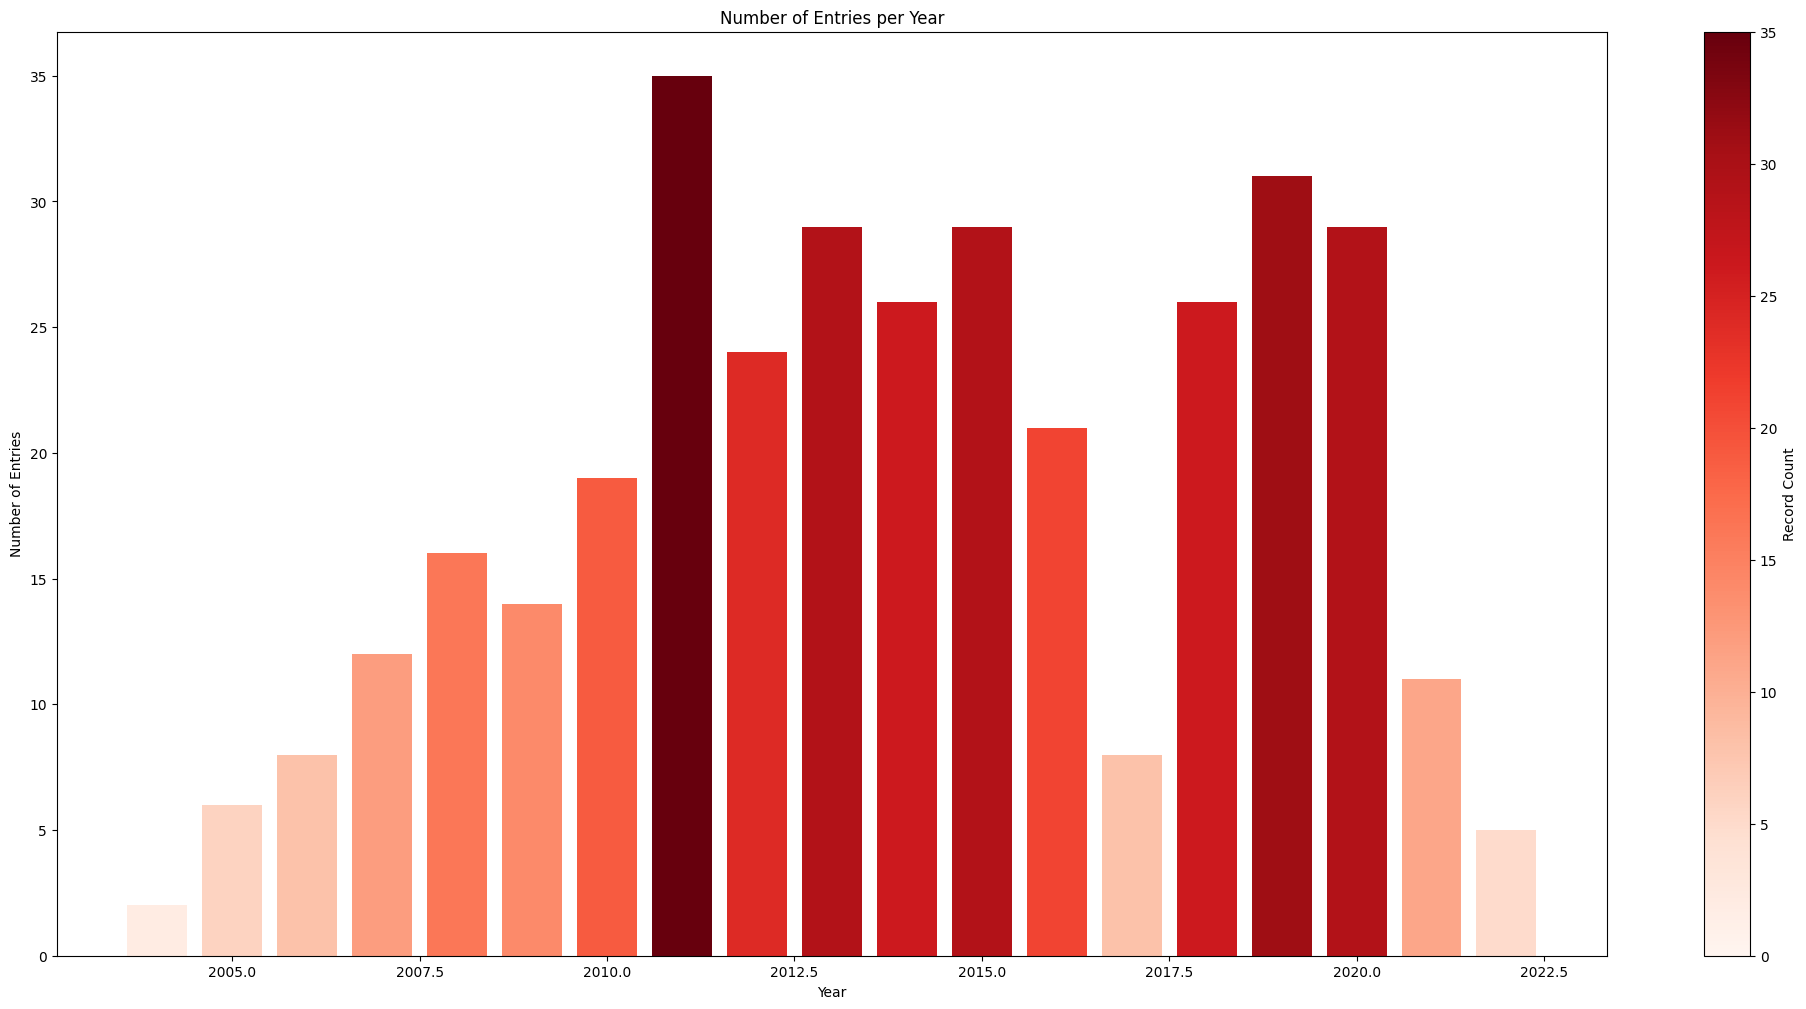

In [42]:
import numpy as np
#convert the years to ints
df_vis['Year'] = df_vis['Year'].astype(int)
# Grouping the data by year
grouped_data = df_vis.groupby('Year').size()

# Sorting the grouped data by year
grouped_data = grouped_data.sort_index()

# Convert the years to whole numbers
grouped_data.index = grouped_data.index.astype(int)

# Creating a bar plot with figsize
fig, ax = plt.subplots(figsize=(25, 12))

# Use a colormap to create a gradient effect
norm = plt.Normalize(0, grouped_data.max())
colors = plt.cm.Reds(norm(grouped_data.values))
bars = ax.bar(grouped_data.index, grouped_data.values, color=colors)

# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Entries')
ax.set_title('Number of Entries per Year')

# Add a colorbar to show the scale
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Reds'), ax=ax, orientation='vertical')
cbar.set_label('Record Count')

# Make the background transparent
# fig.patch.set_alpha(0.0)
# ax.patch.set_alpha(0.0)

# Save the plot with a transparent background
plt.savefig('graphs/entries.png', bbox_inches='tight', pad_inches=0.1)

# Display the plot
plt.show()


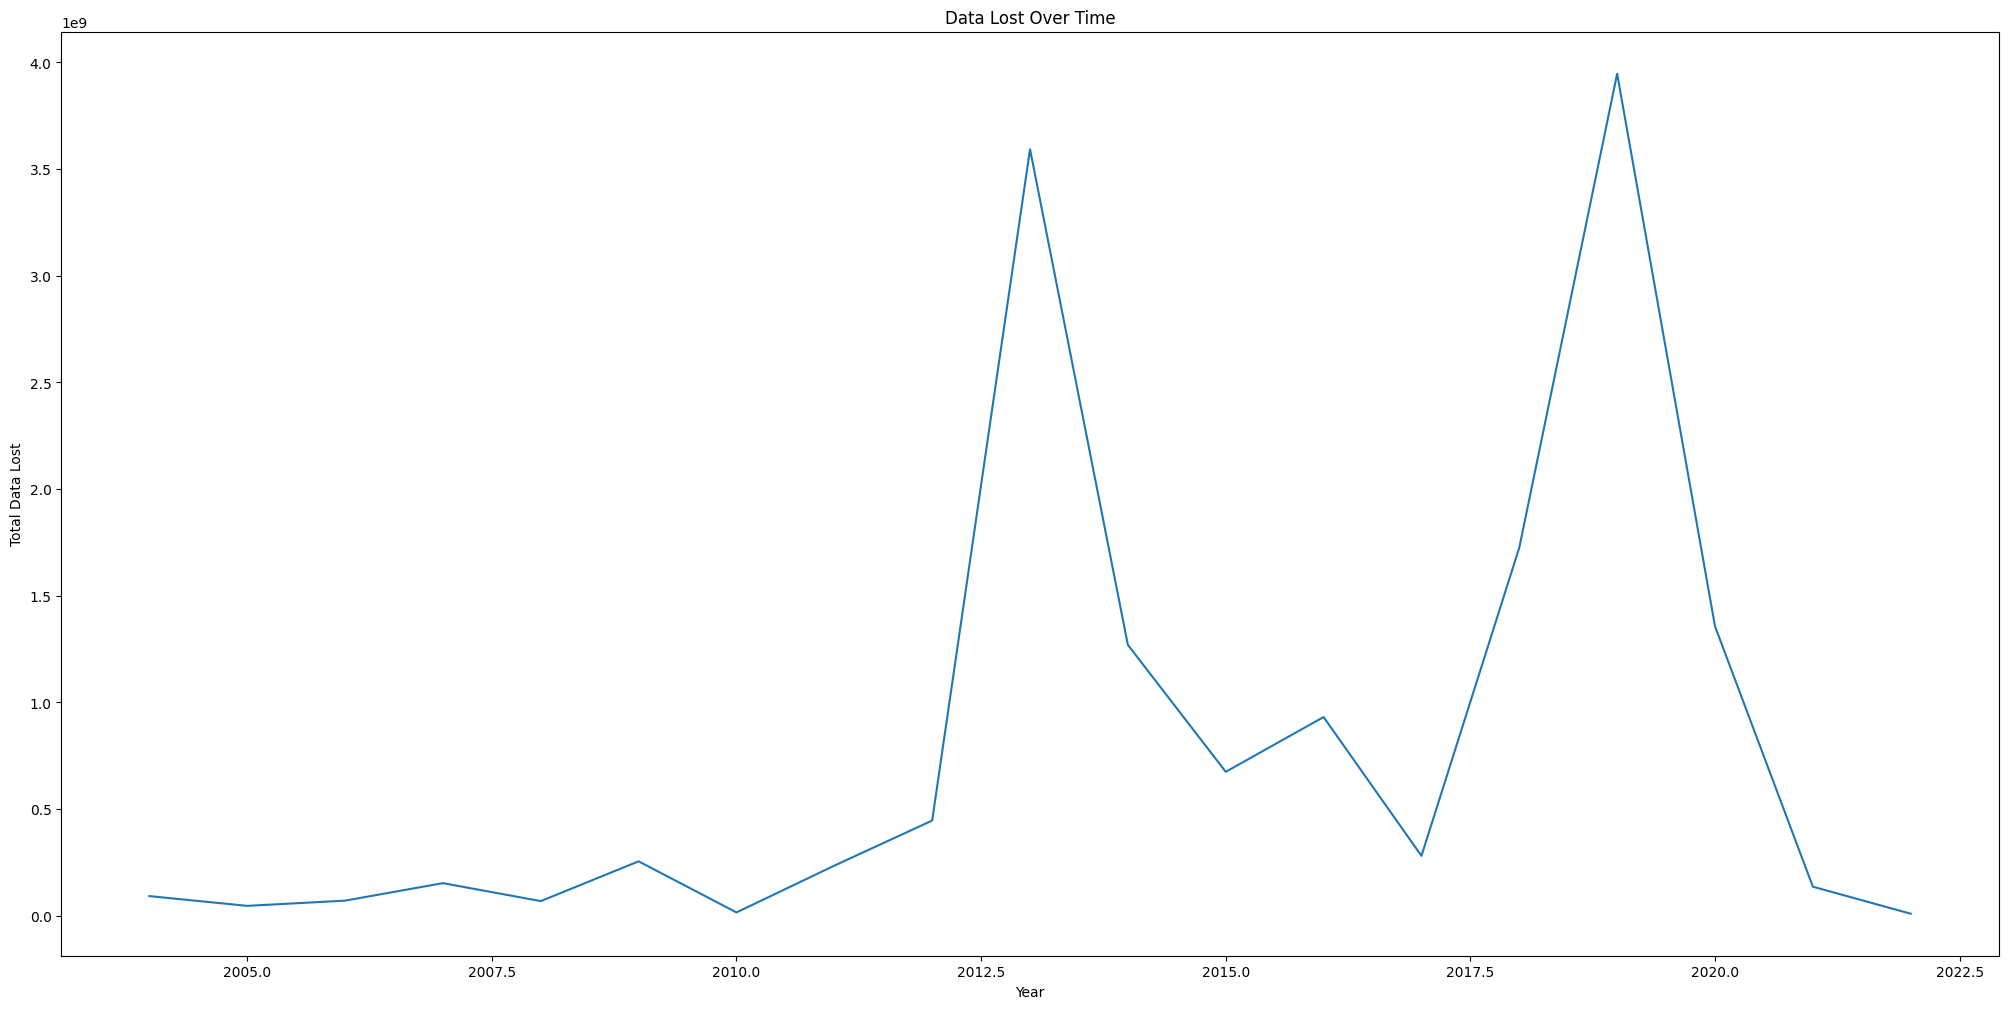

In [43]:
# Group the data by year and sum the records for each year
data_lost_over_time = df_vis.groupby('Year')['Records'].sum()

# Create a line plot for data lost over time
data_lost_over_time.plot(kind='line', figsize=(25, 12))
plt.title("Data Lost Over Time")
plt.xlabel("Year")
plt.ylabel("Total Data Lost")
#save the plot as "records_line_plot.png" in graphs
plt.savefig('graphs/records_line_plot.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

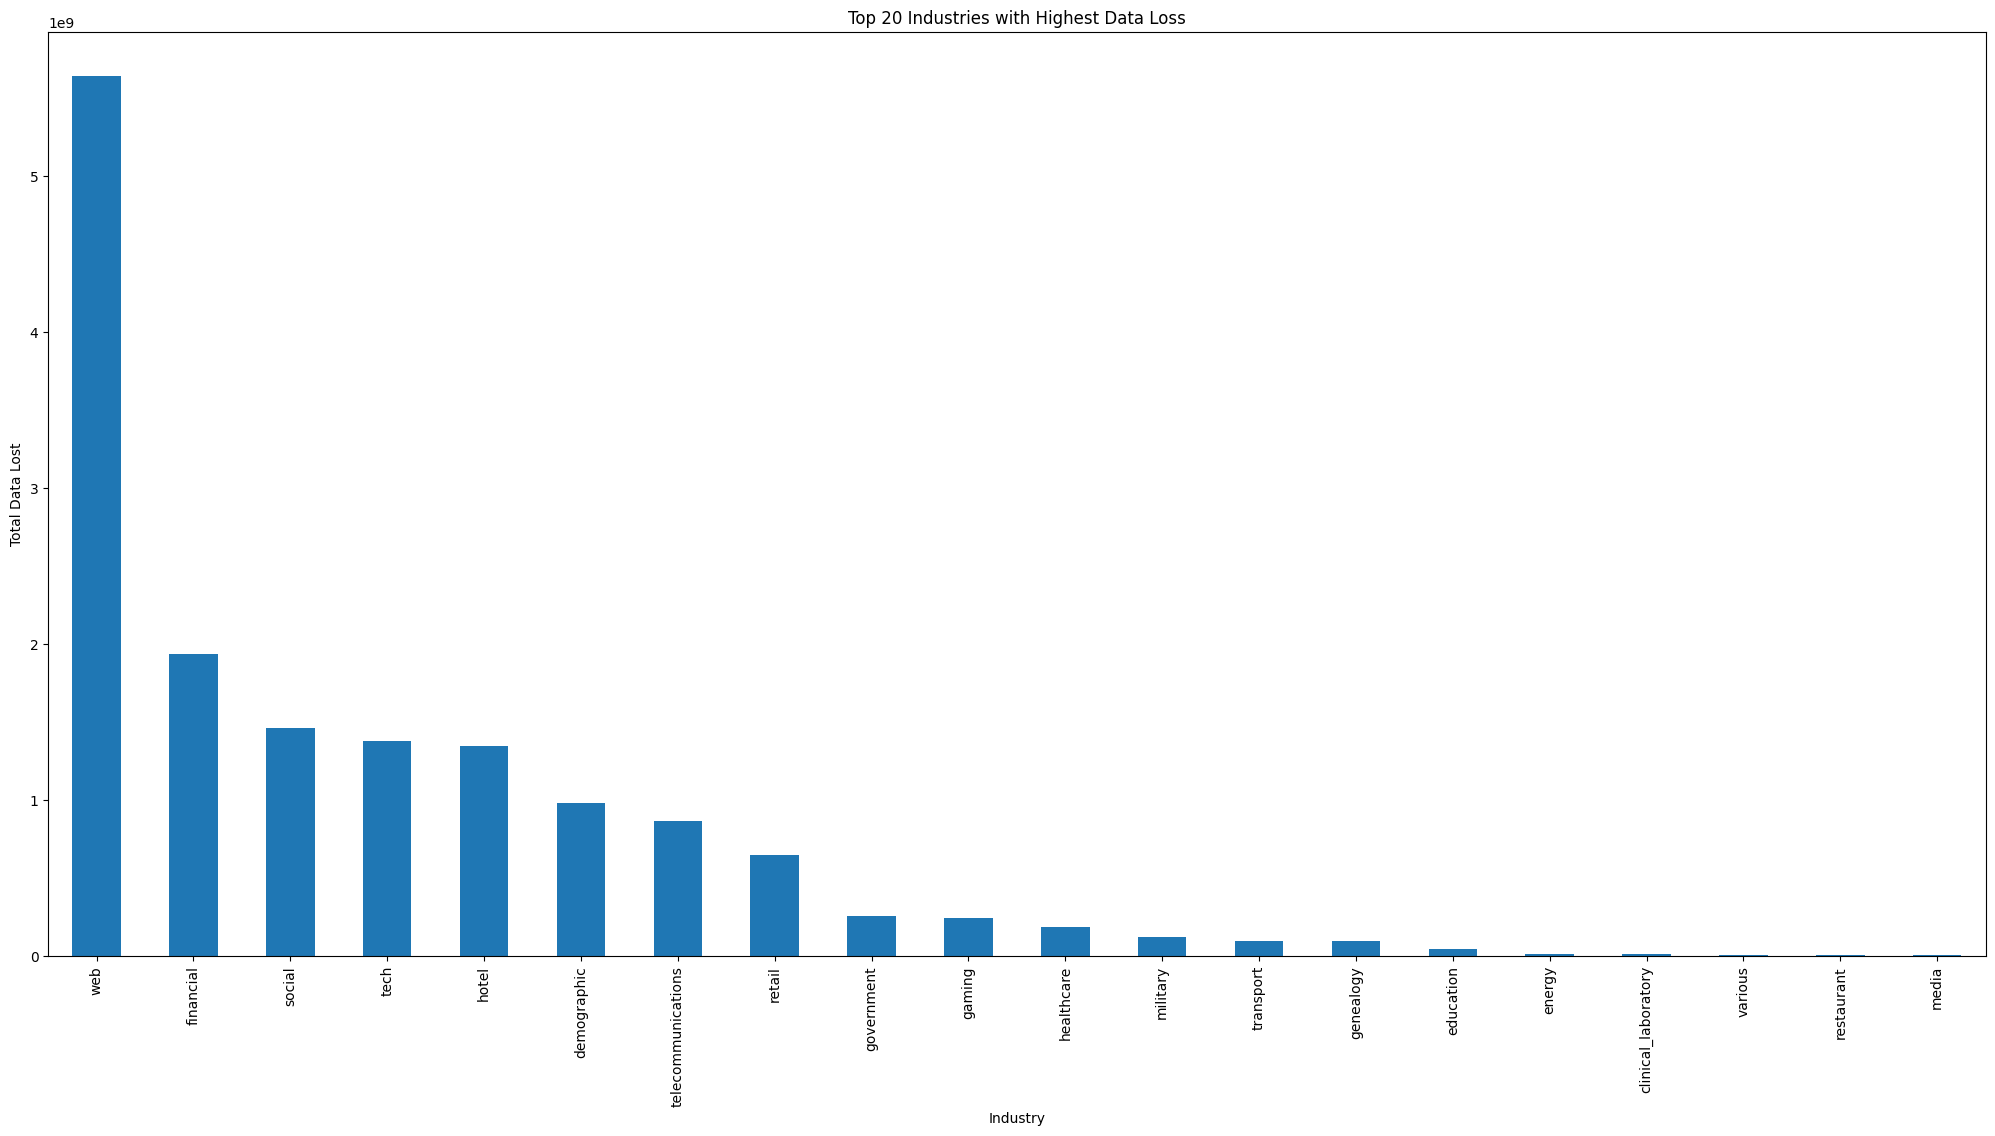

In [44]:
# Group the data by industry and sum the records for each industry, then select the top 20 industries
top_20_industries = df_vis.groupby('Organization type')['Records'].sum().nlargest(20)

# Create a bar plot for the top 10 industries with the highest data loss
top_20_industries.plot(kind='bar', figsize=(25, 12))
plt.title("Top 20 Industries with Highest Data Loss")
plt.xlabel("Industry")
plt.ylabel("Total Data Lost")
plt.xticks(rotation=90)


plt.show()

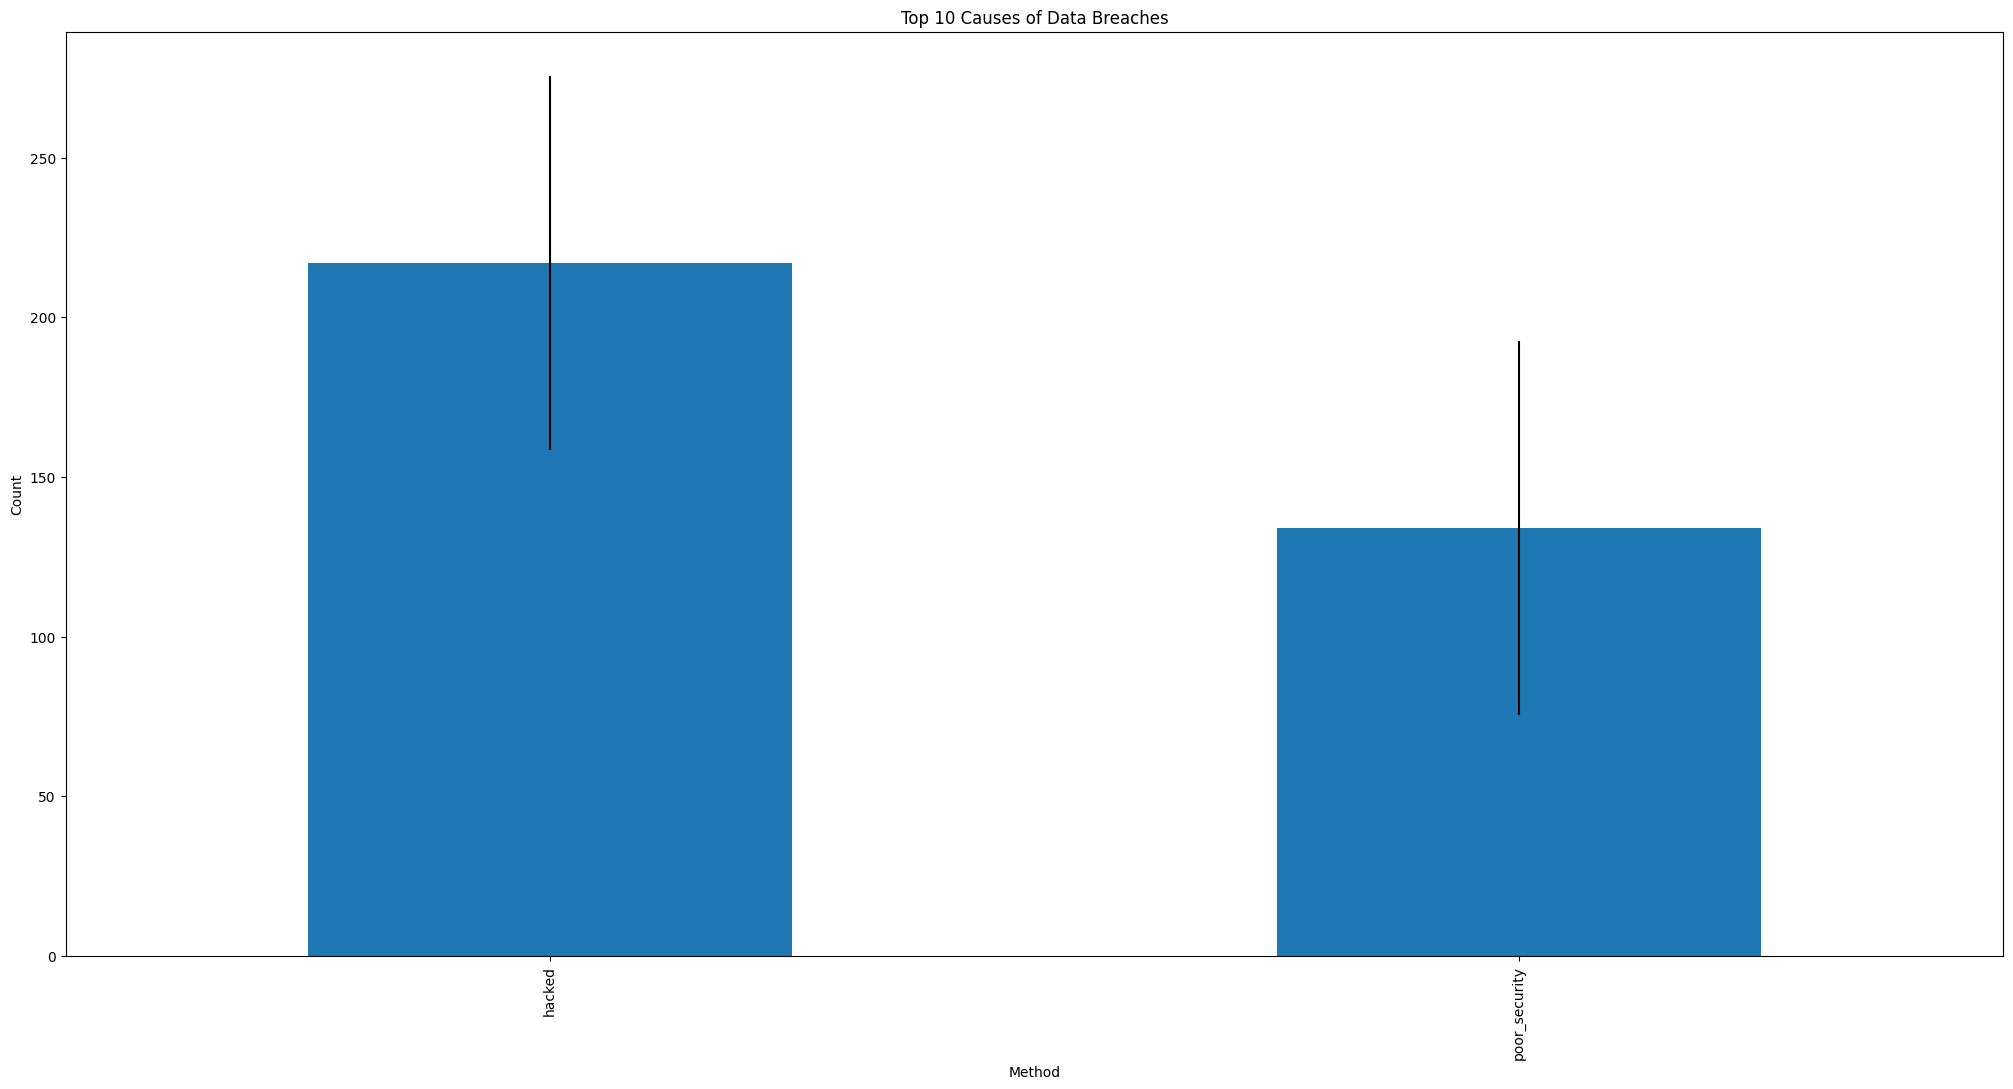

In [45]:
# Group the data by the method and count the occurrences, then select the top 10 causes
top_10_causes = df_vis['Method'].value_counts().nlargest(10)

# Create a bar plot for the top 10 causes of data breaches
top_10_causes.plot(kind='bar', figsize=(25, 12))
plt.title("Top 10 Causes of Data Breaches")
plt.xlabel("Cause")
plt.ylabel("Count")
plt.xticks(rotation=90)
top_10_causes.plot(kind='bar', figsize=(25, 12), yerr=df_vis['Method'].value_counts().std())
plt.show()


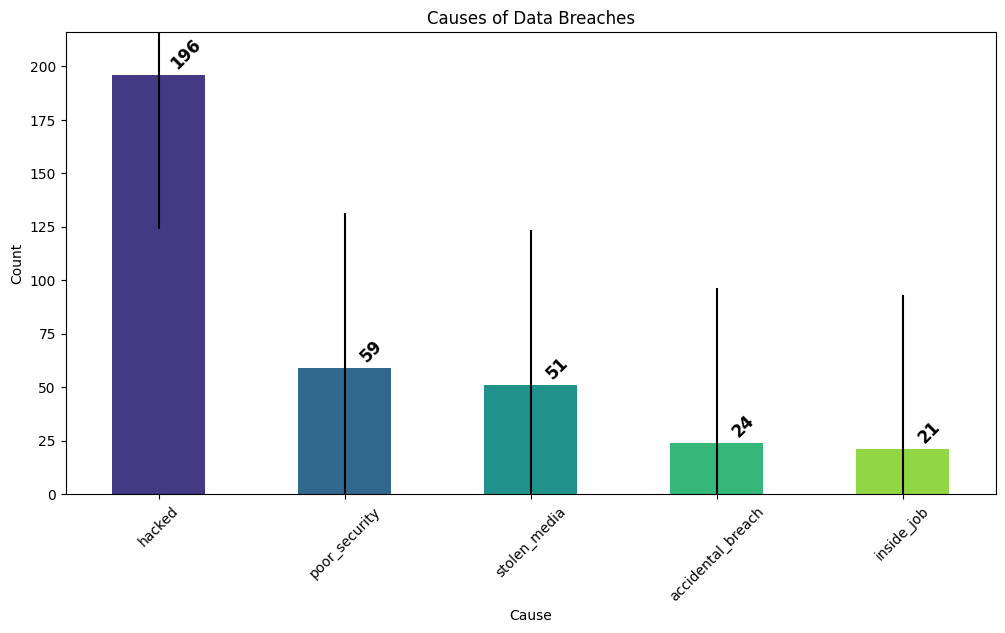

In [46]:
top_causes = df_class['Method'].value_counts()

# Set up a color palette with a unique color for each bar
colors = sns.color_palette('viridis', len(top_causes))
top_limit = top_causes.max() + 20
plt.ylim(bottom=0, top = top_limit)
# Create a bar plot for the causes of data breaches
top_causes.plot(kind='bar', figsize=(12, 6), color=colors, yerr=df_class['Method'].value_counts().std())
plt.title("Causes of Data Breaches")
plt.xlabel("Cause")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add labels to each bar containing the count of entries for each cause. offset the labels to the right by 0.1
for index, value in enumerate(top_causes):
    plt.text(index + 0.145, value + 1, str(value), ha='center', va='bottom' , rotation=45, fontweight='bold', color='black', fontsize=12)


#save the plot as "breachcauses.png" in the directory called graphs
plt.savefig('graphs/breachcauses.png', bbox_inches='tight')
plt.show()


when we calculate the error bars, theres an upper and lower bound, the upper bound is the mean + the standard deviation, the lower bound is the mean - the standard deviation.
So, drawing a line through the lower bound, and it doesnt touch the other line, that means that the difference is statistically significant.

We may want to exclude the data that is statistically significant, because it may be an outlier.

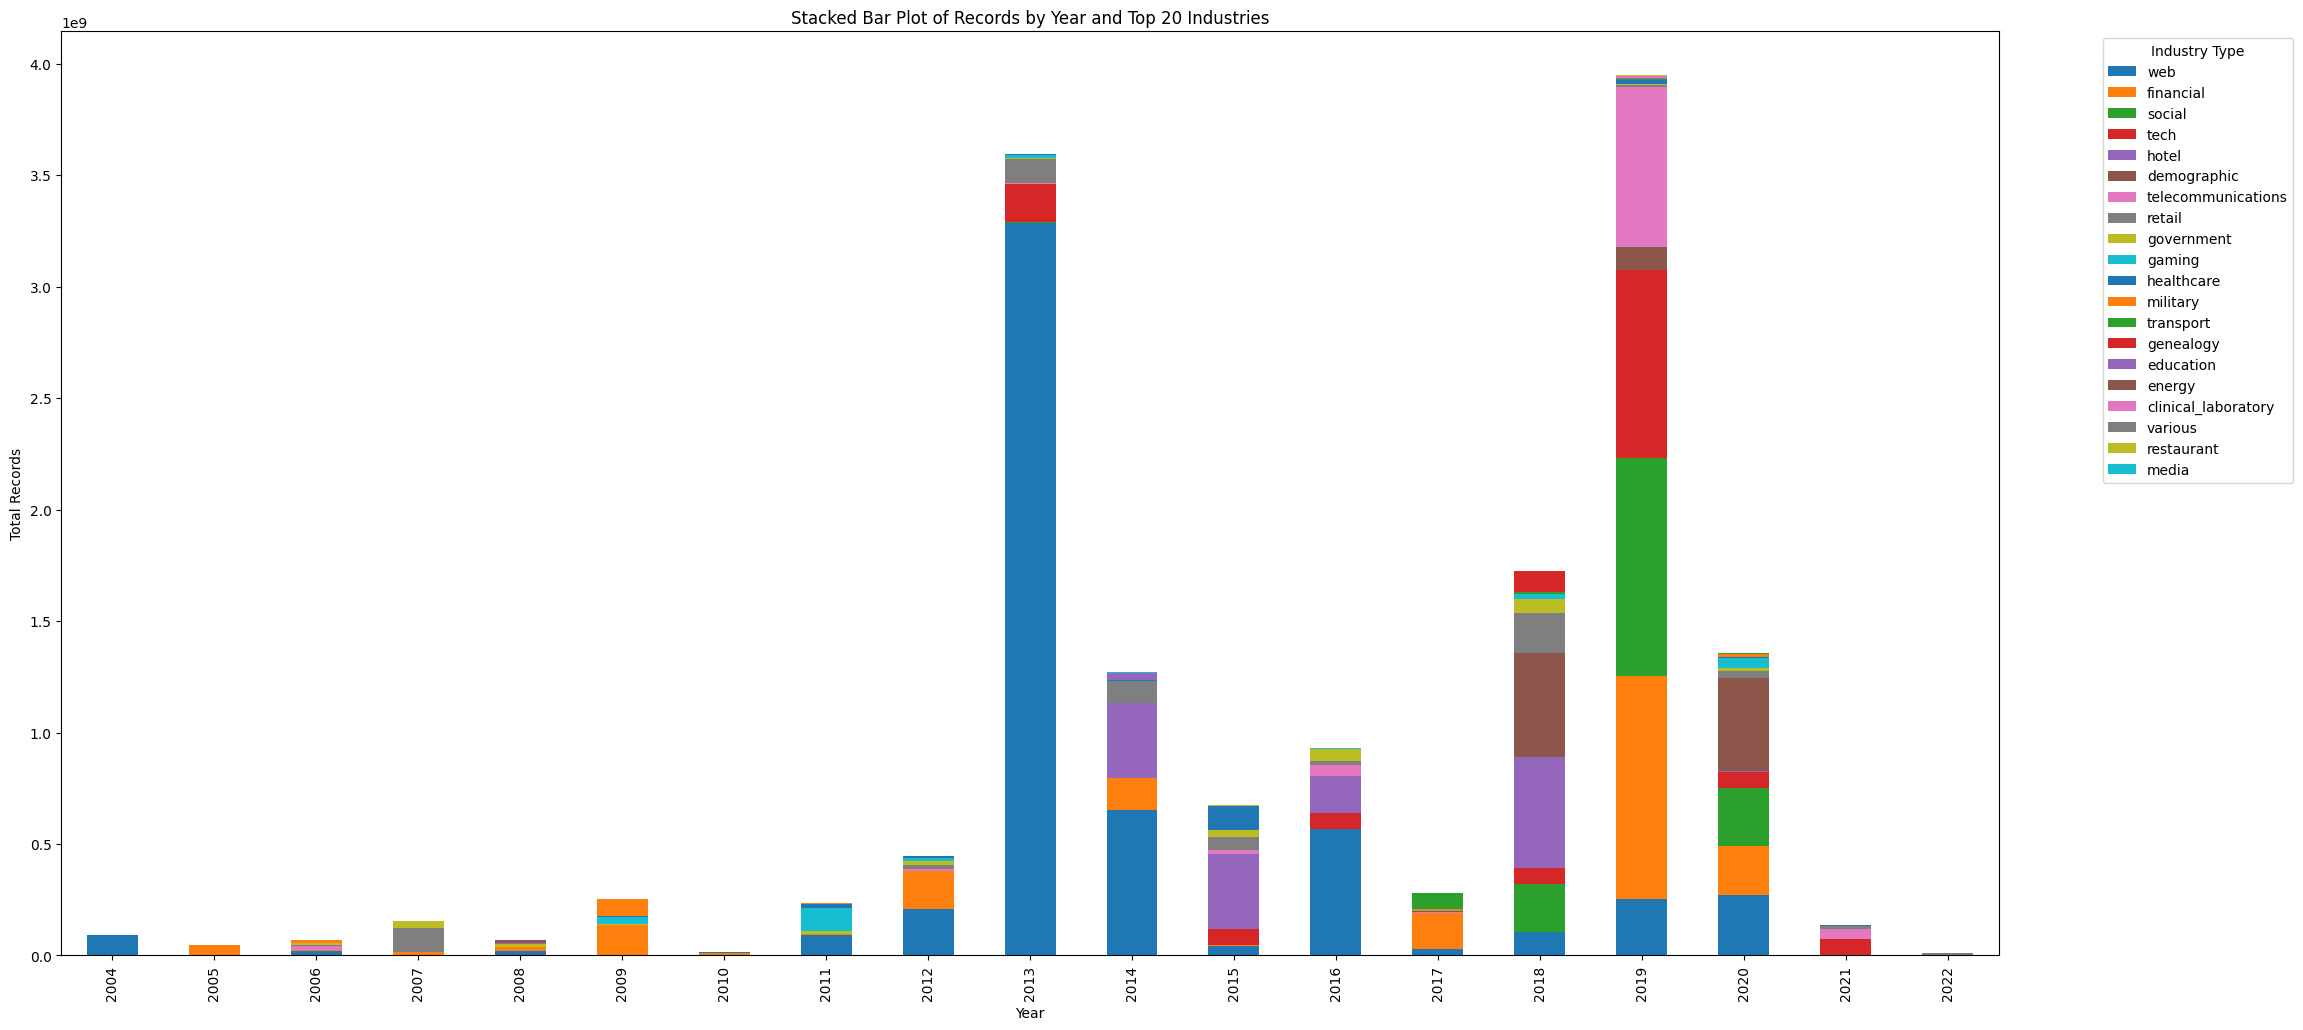

In [47]:
# Grouping the data by year and industry and summing the 'Records' column
records_by_year_and_industry = df_vis.groupby(['Year', 'Organization type'])['Records'].sum().unstack()

# Finding the top 20 industries based on total records
top_20_industries = records_by_year_and_industry.sum().sort_values(ascending=False).head(20).index

# Filtering the DataFrame to include only the top 20 industries
records_by_year_and_industry_top20 = records_by_year_and_industry[top_20_industries]

# Creating a stacked bar plot for records by year and industry (top 20)
records_by_year_and_industry_top20.plot(kind='bar', stacked=True, figsize=(25, 12))

# Adding labels and title
plt.title("Stacked Bar Plot of Records by Year and Top 20 Industries")
plt.xlabel("Year")
plt.ylabel("Total Records")
plt.xticks(rotation=90)
plt.legend(title='Industry Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

#save the plot as "industryrecords.png" in the directory called graphs
plt.savefig('graphs/industryrecords.png', bbox_inches='tight')
# Display the plot
plt.show()

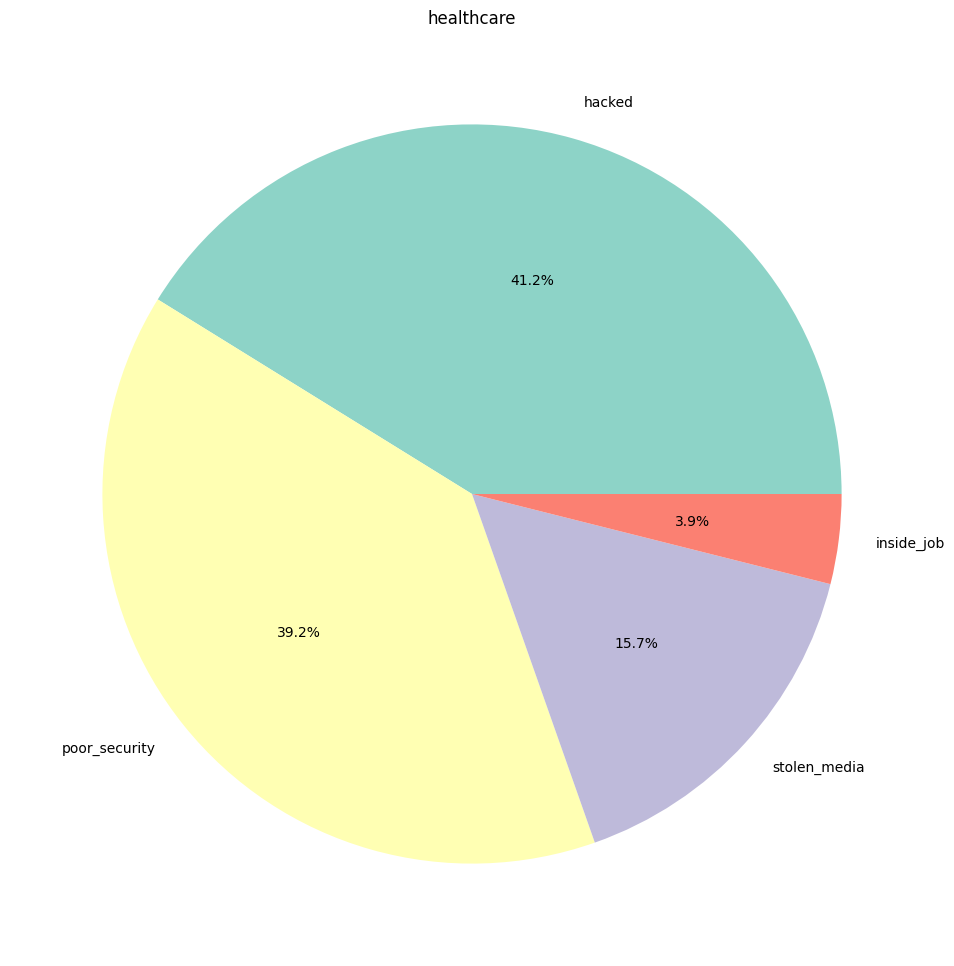

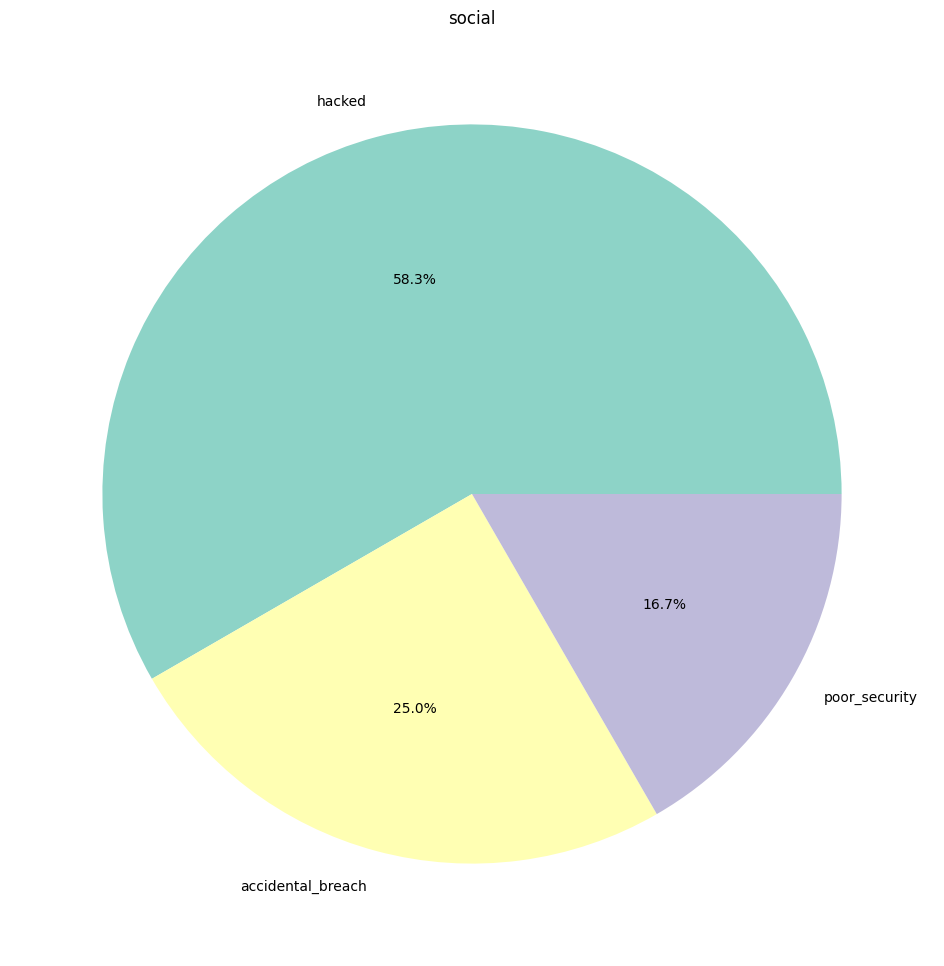

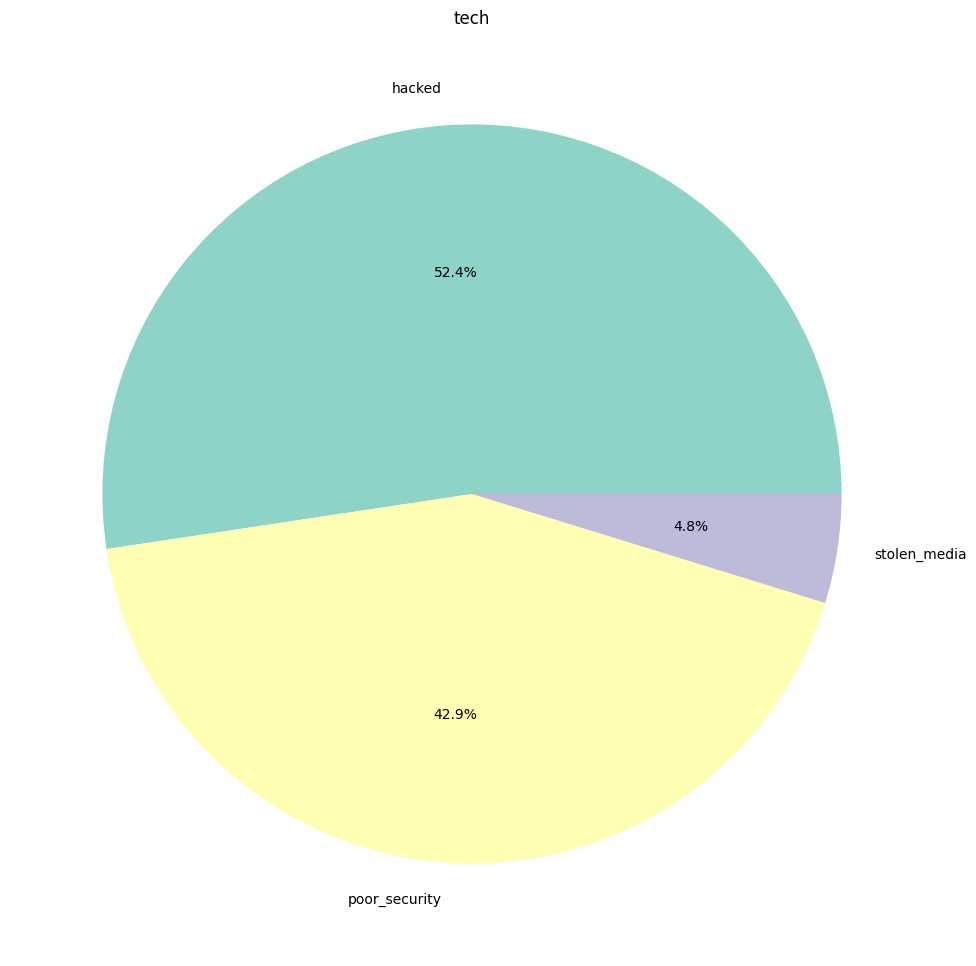

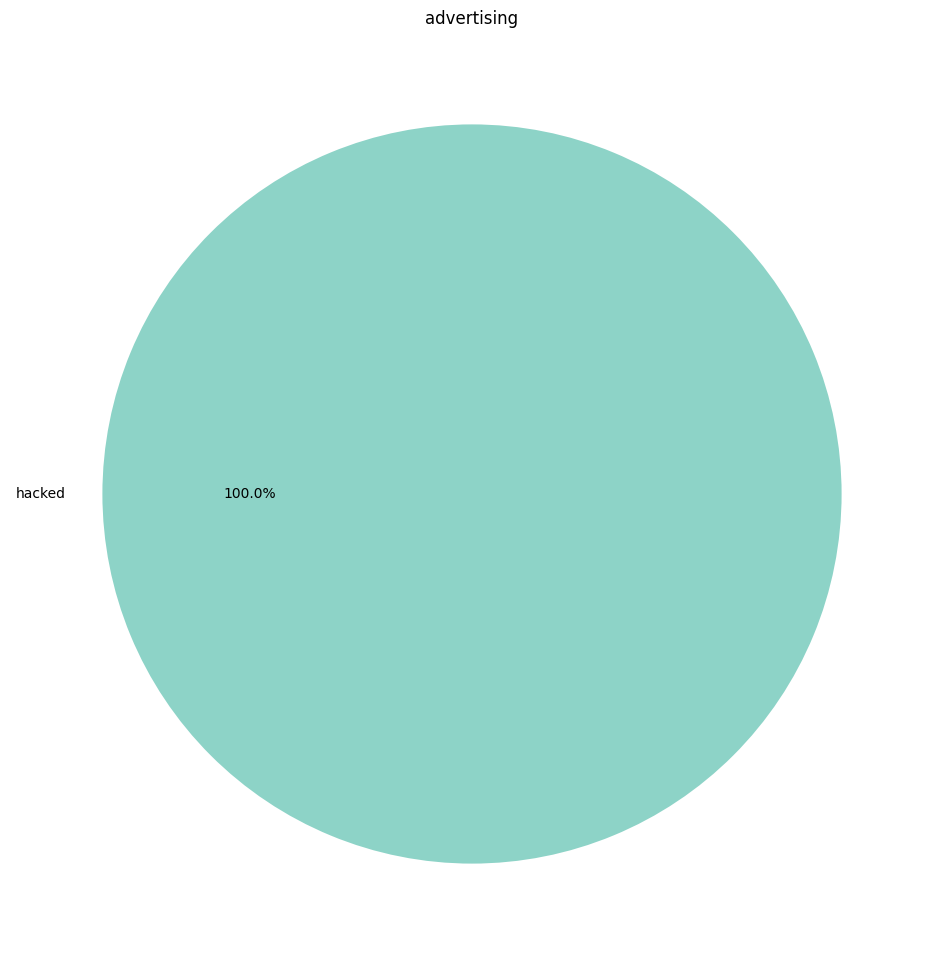

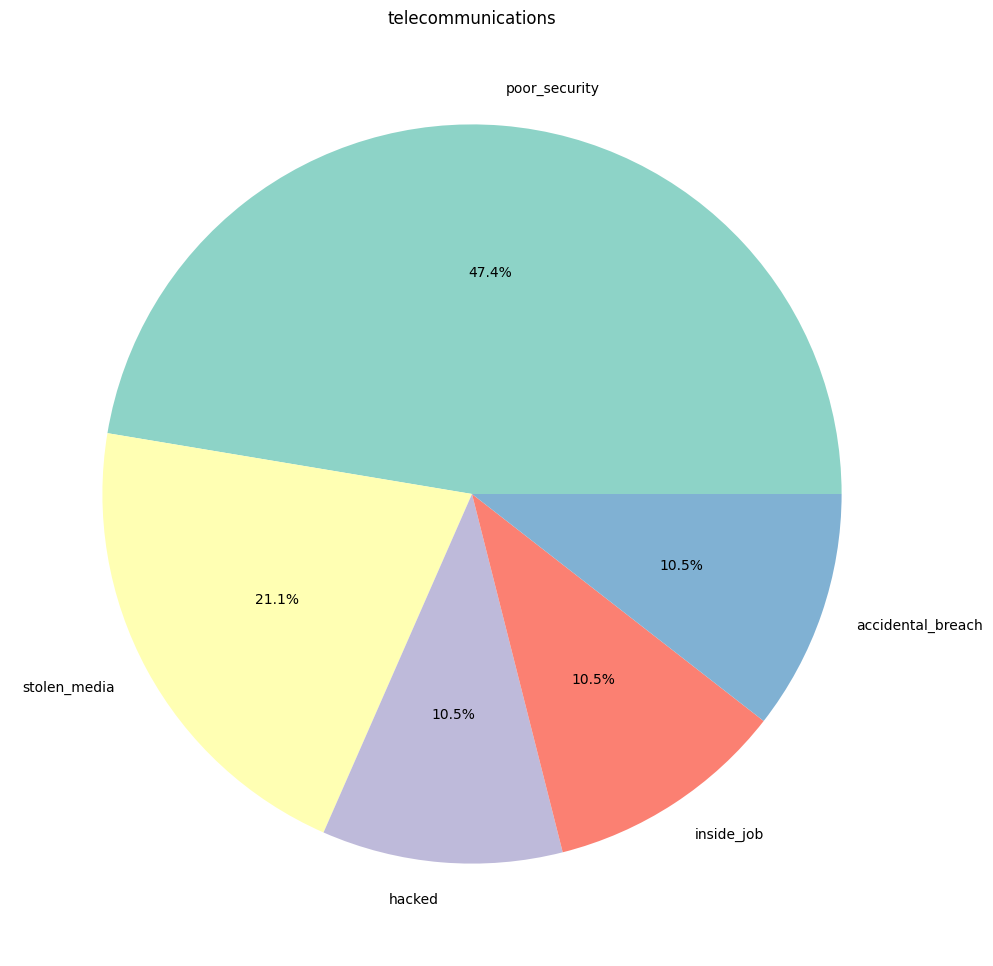

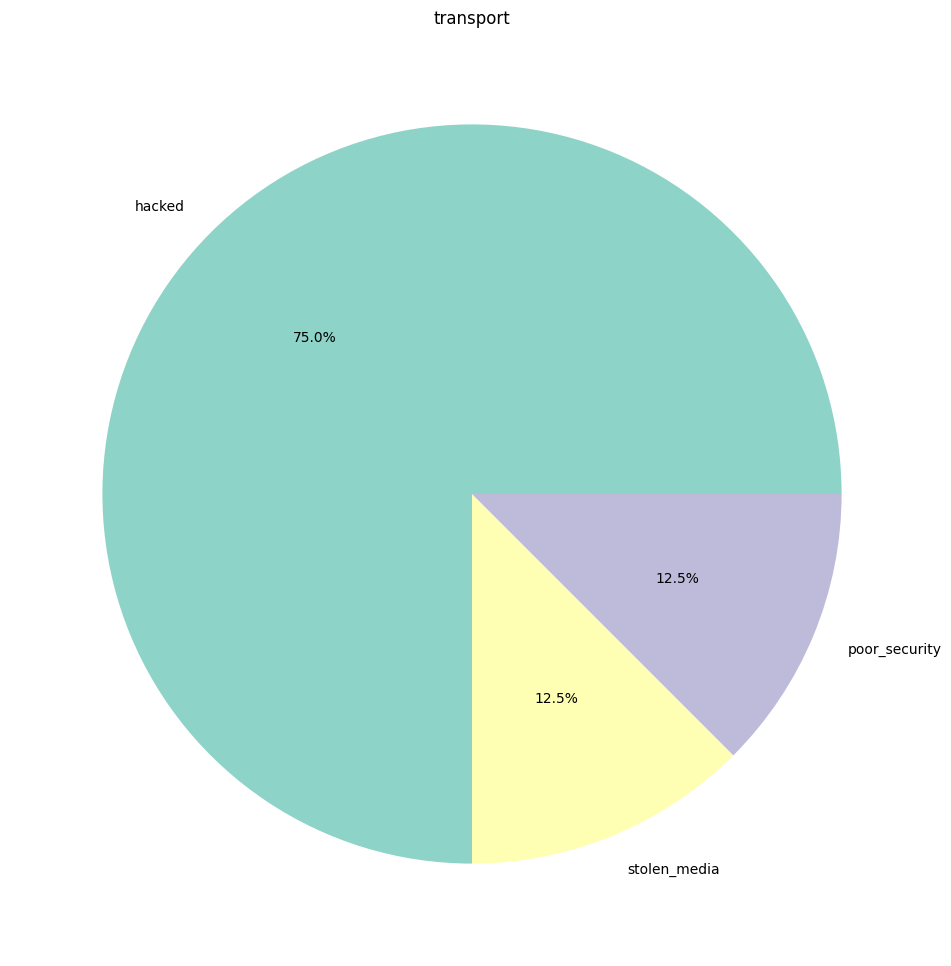

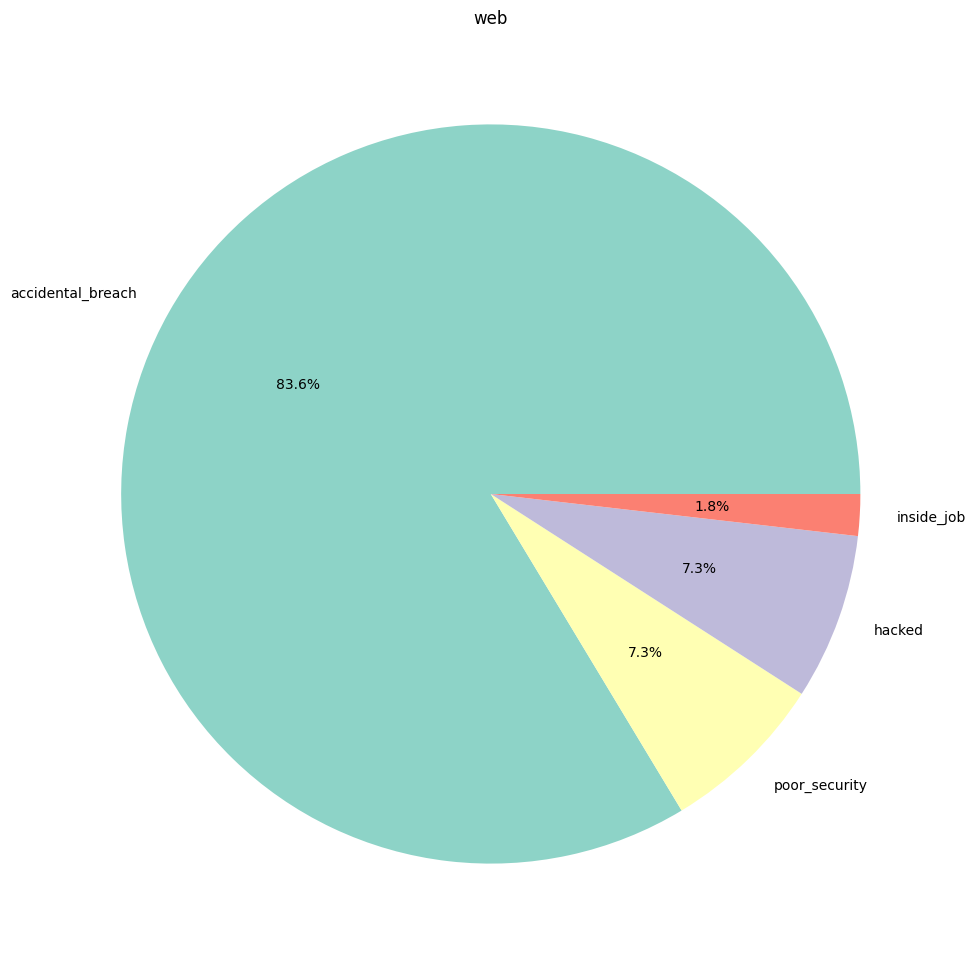

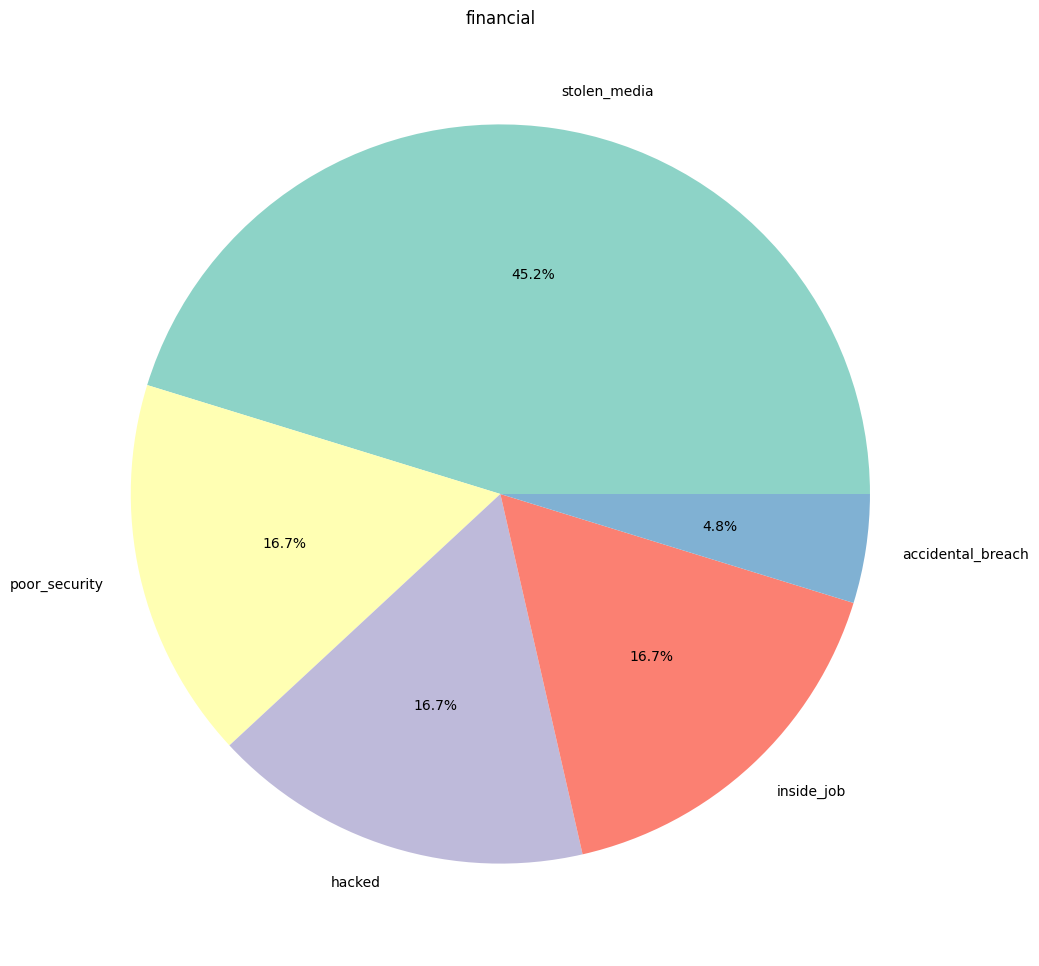

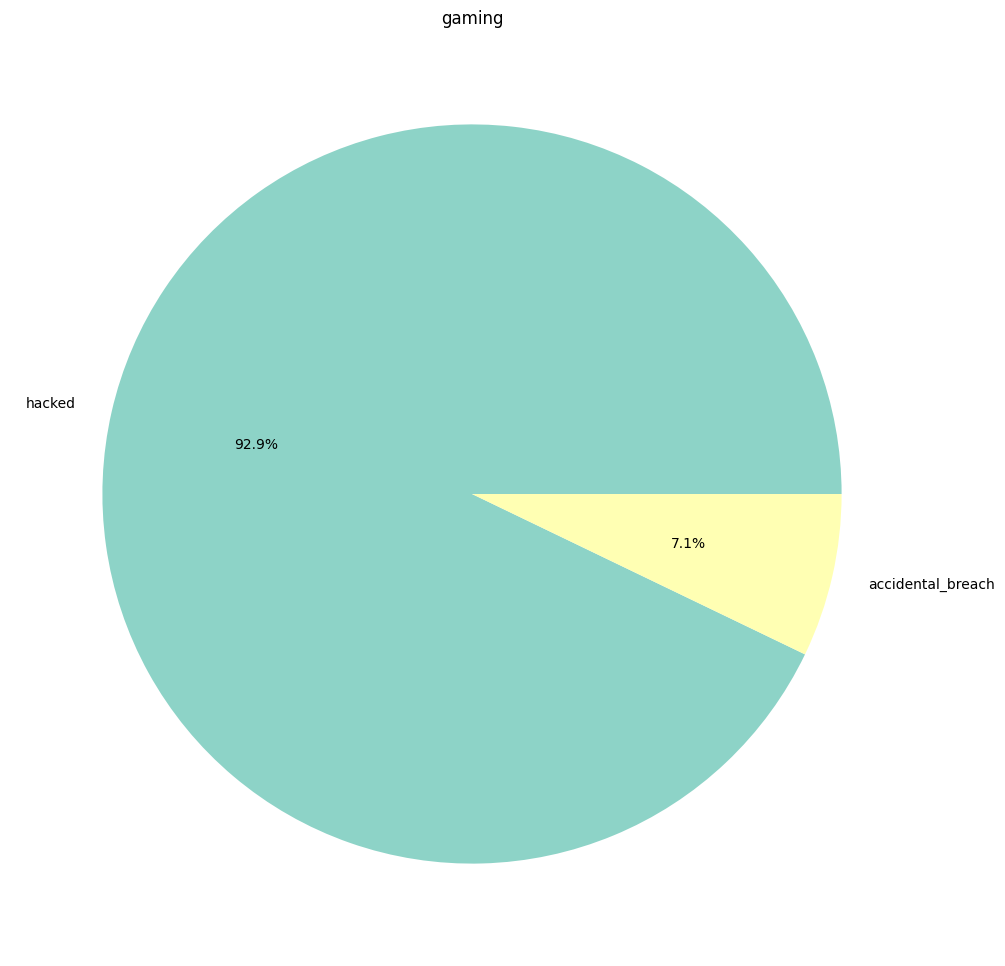

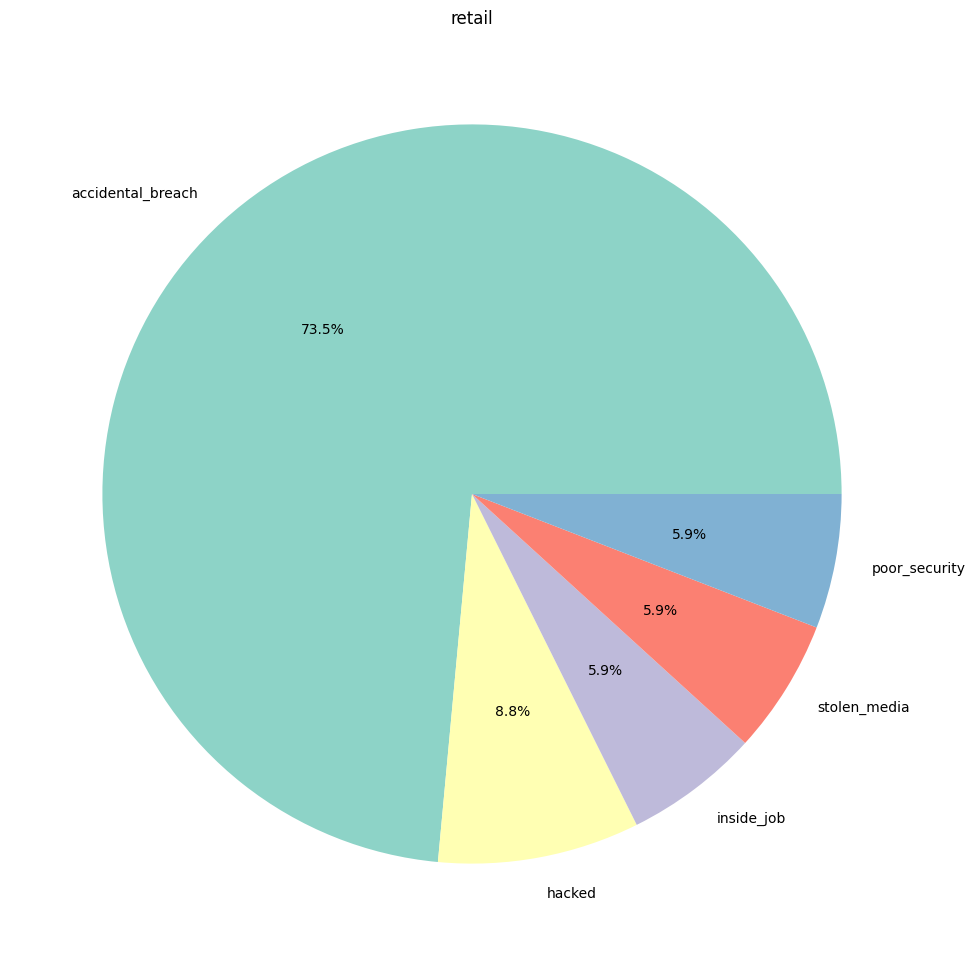

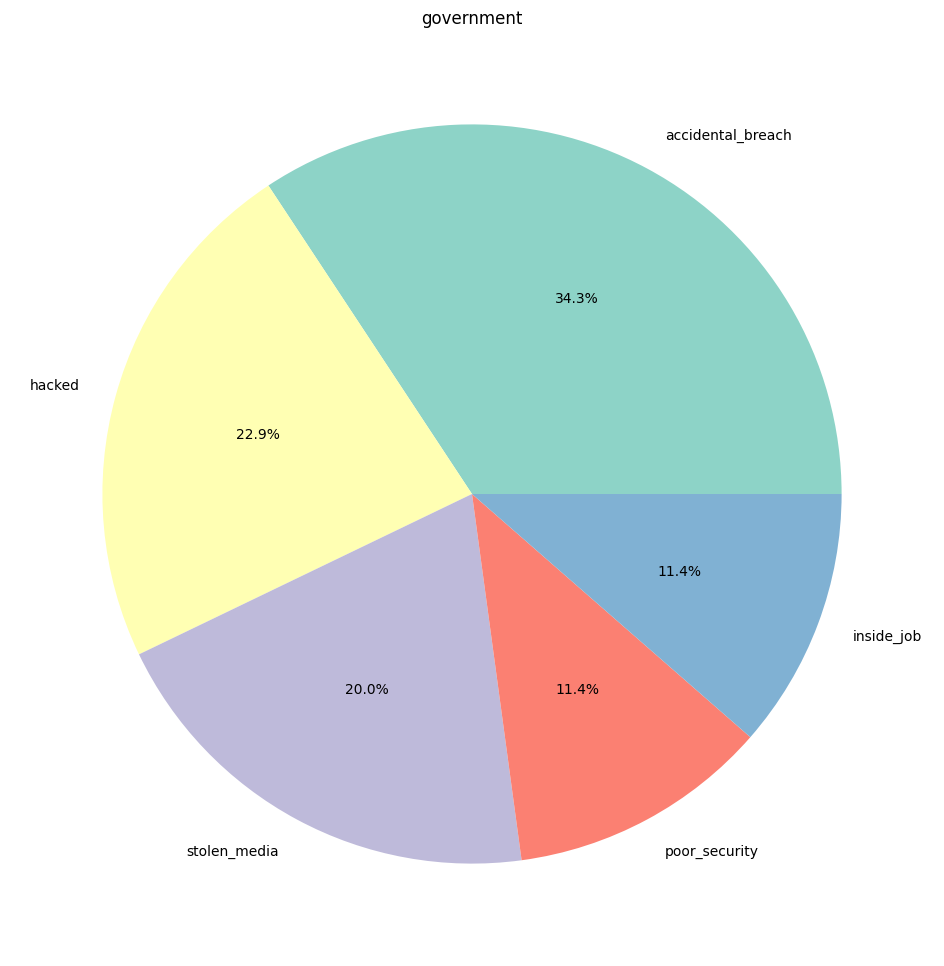

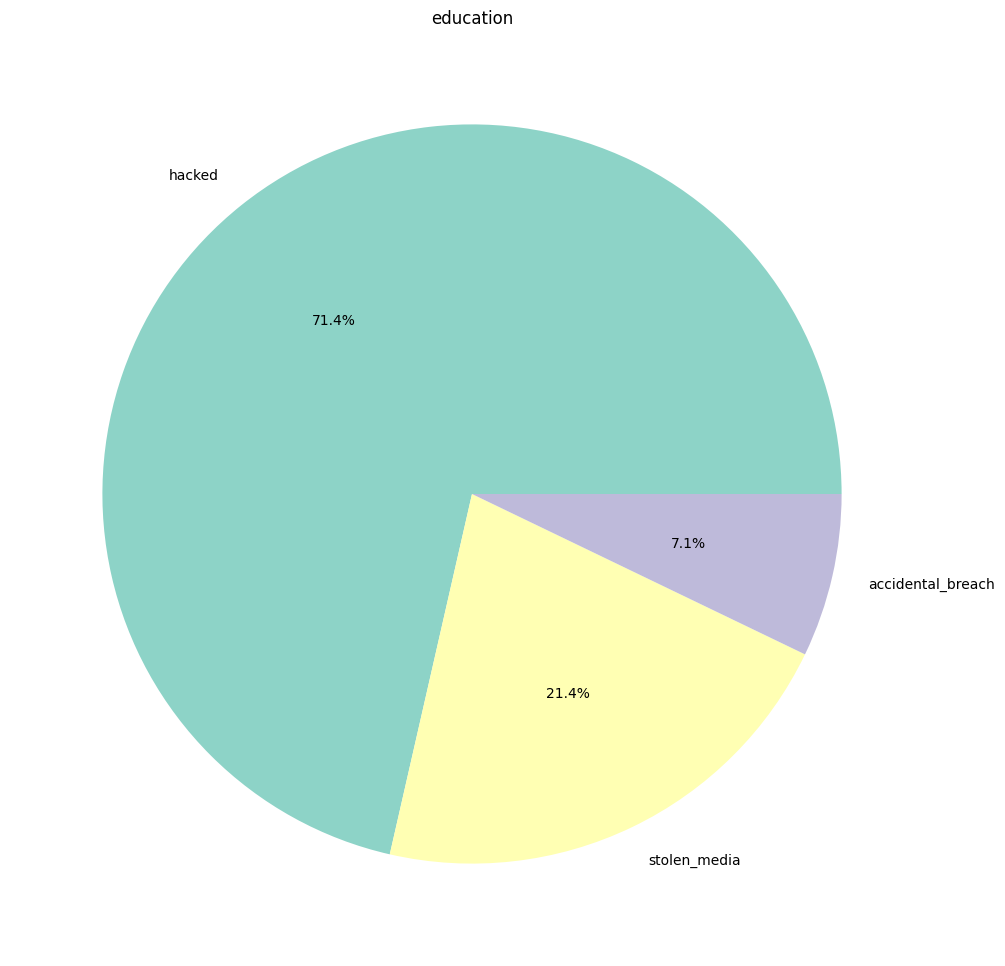

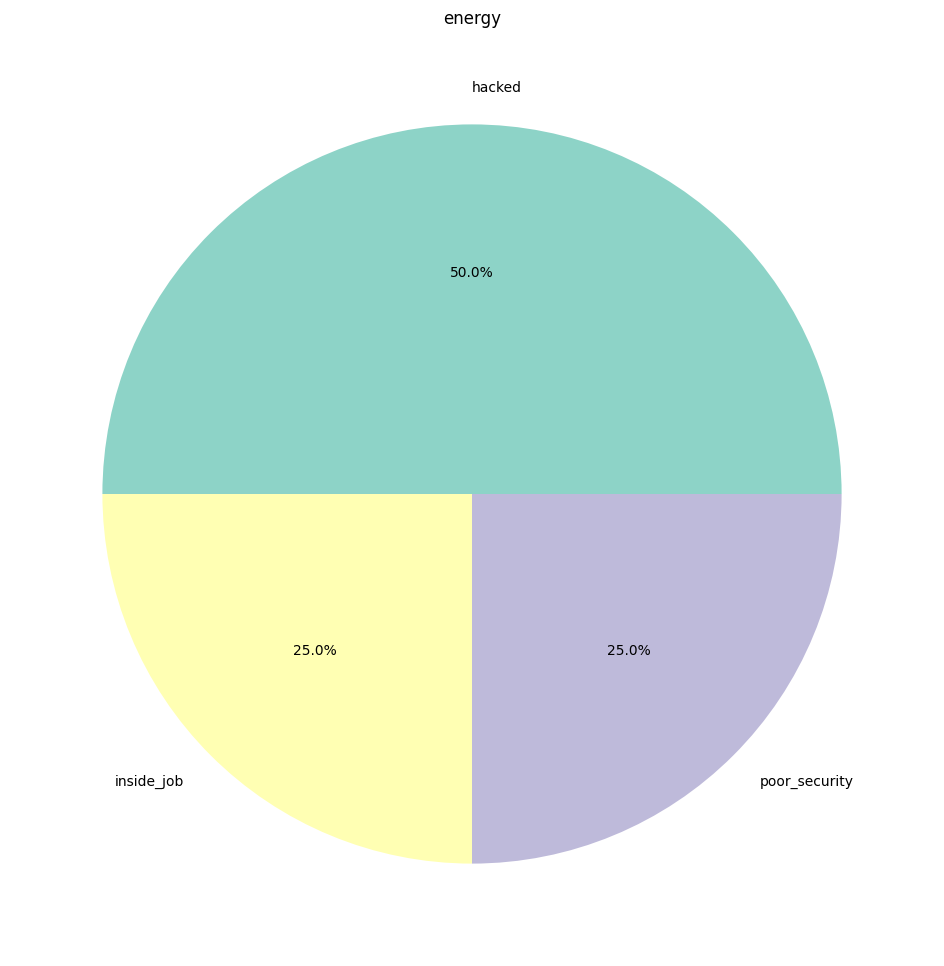

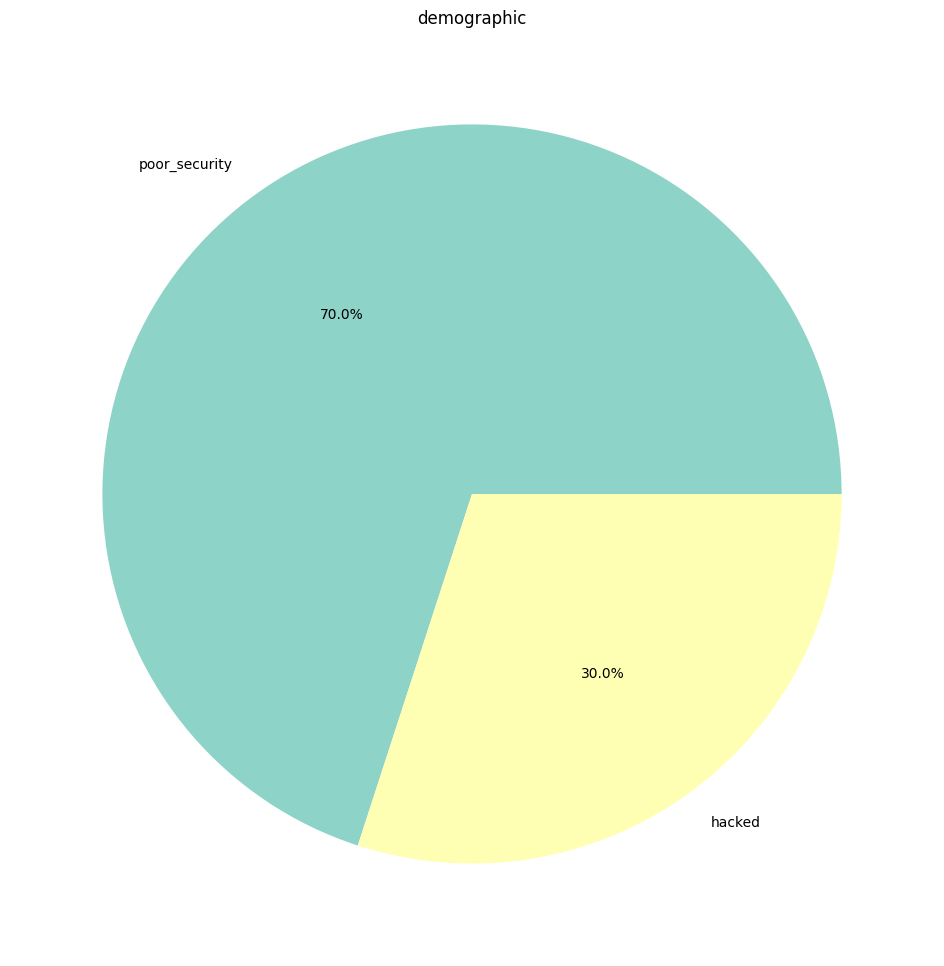

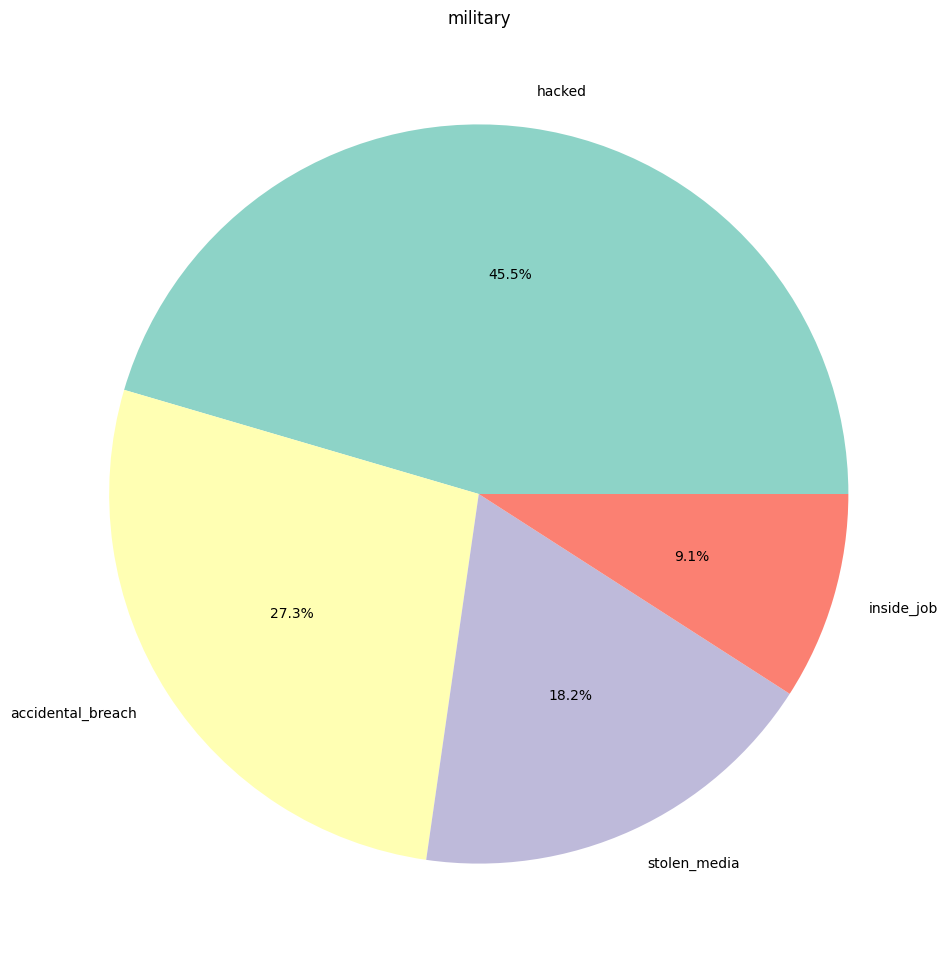

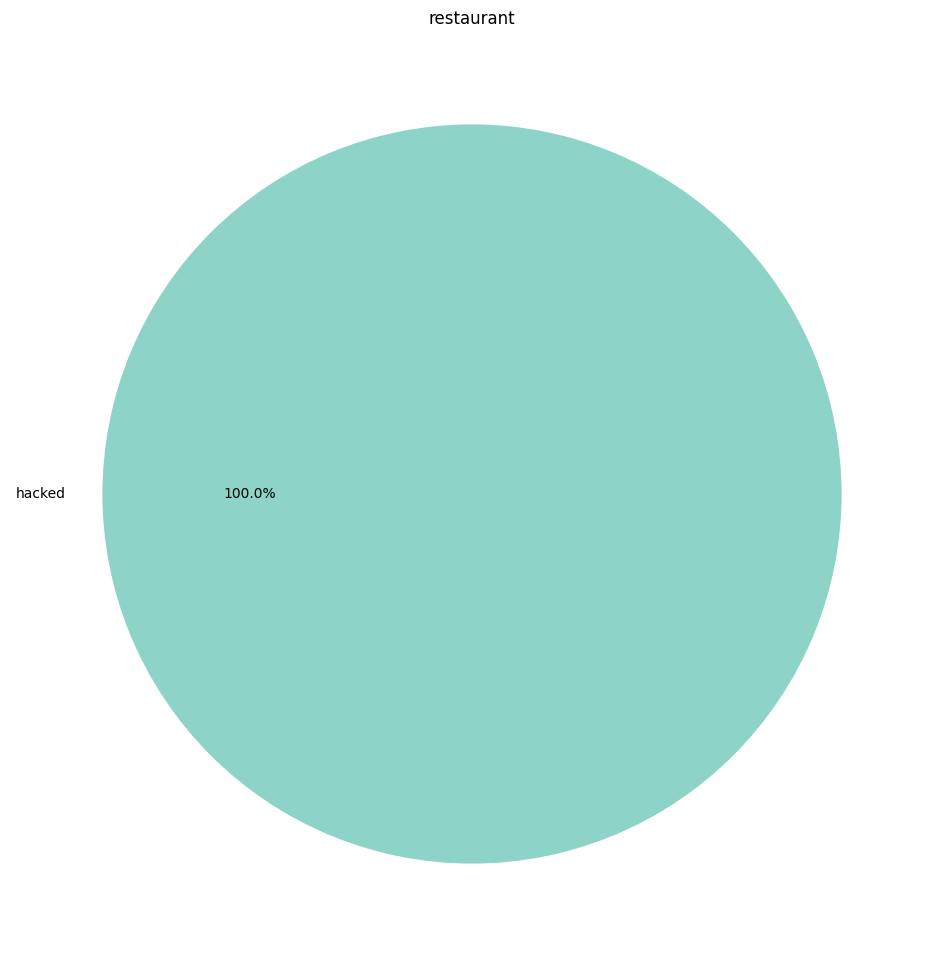

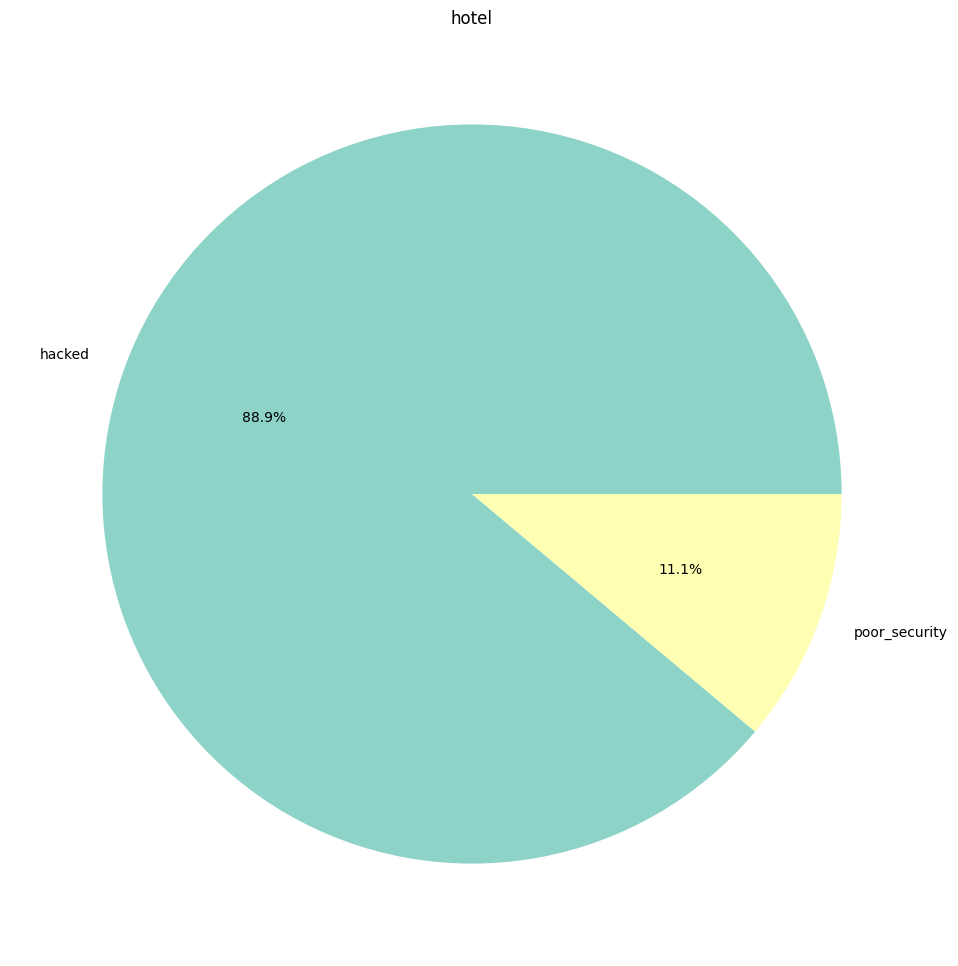

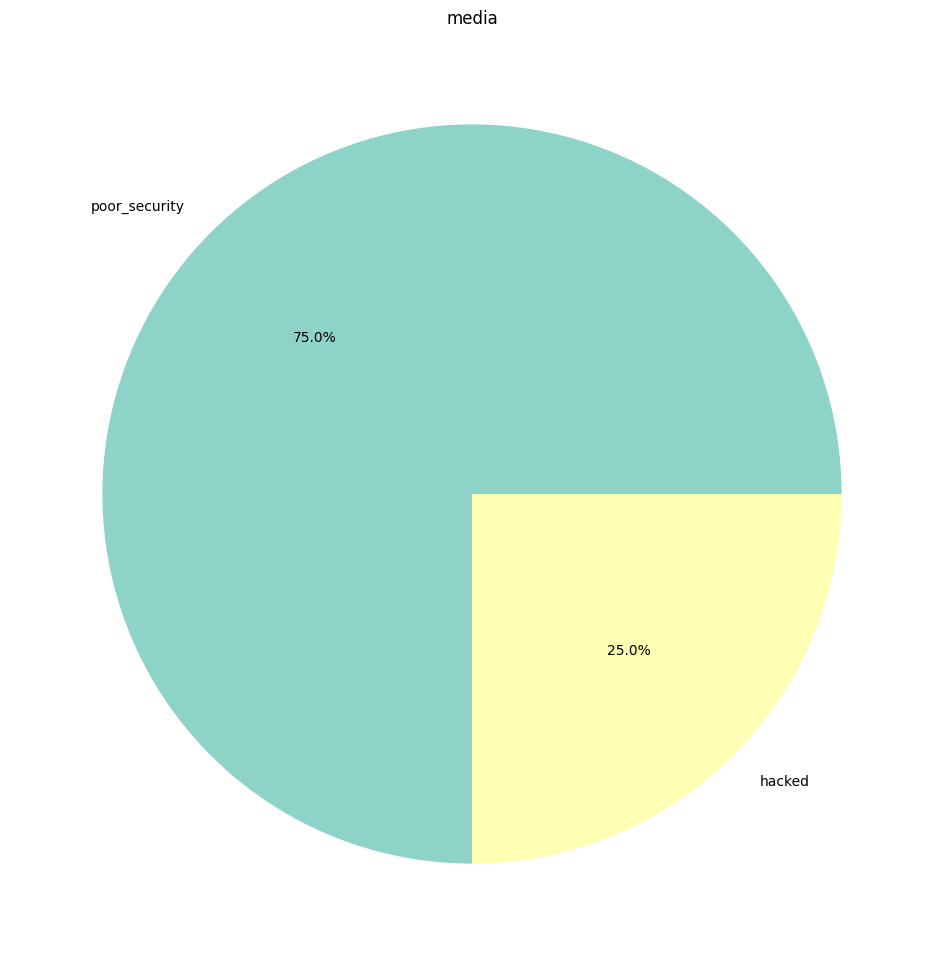

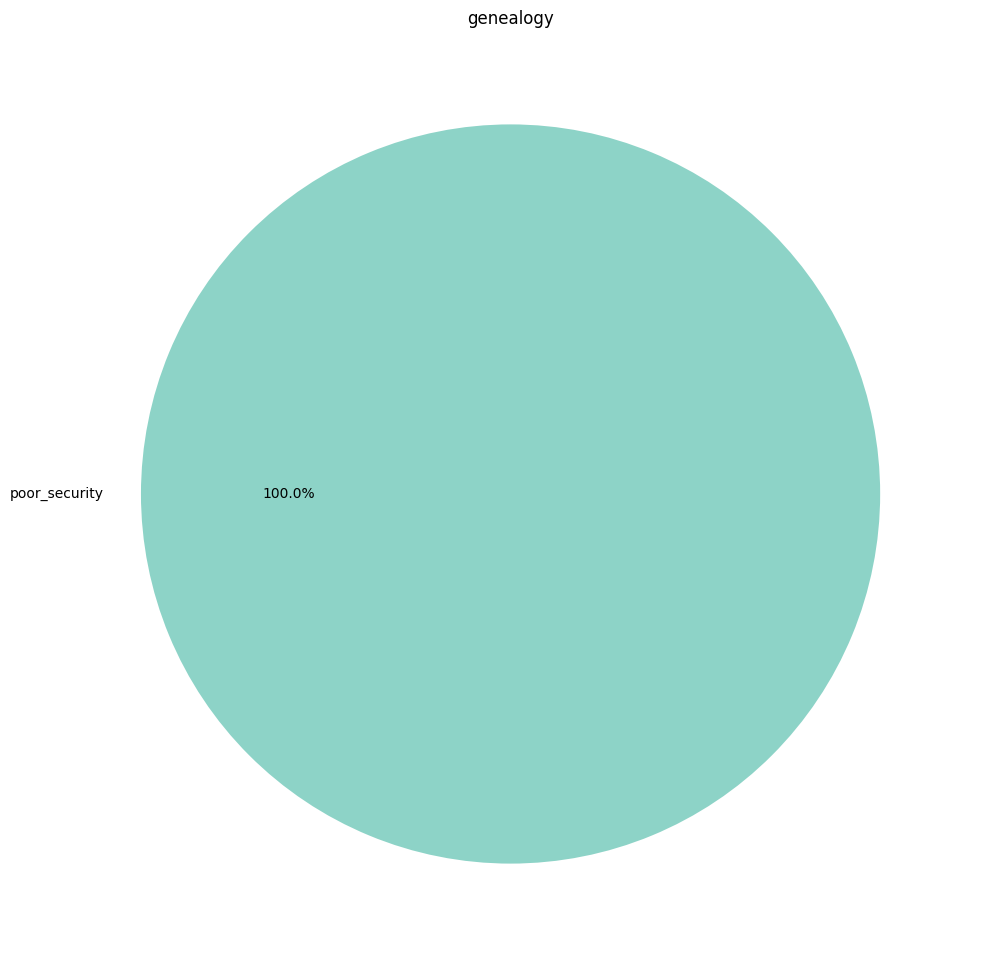

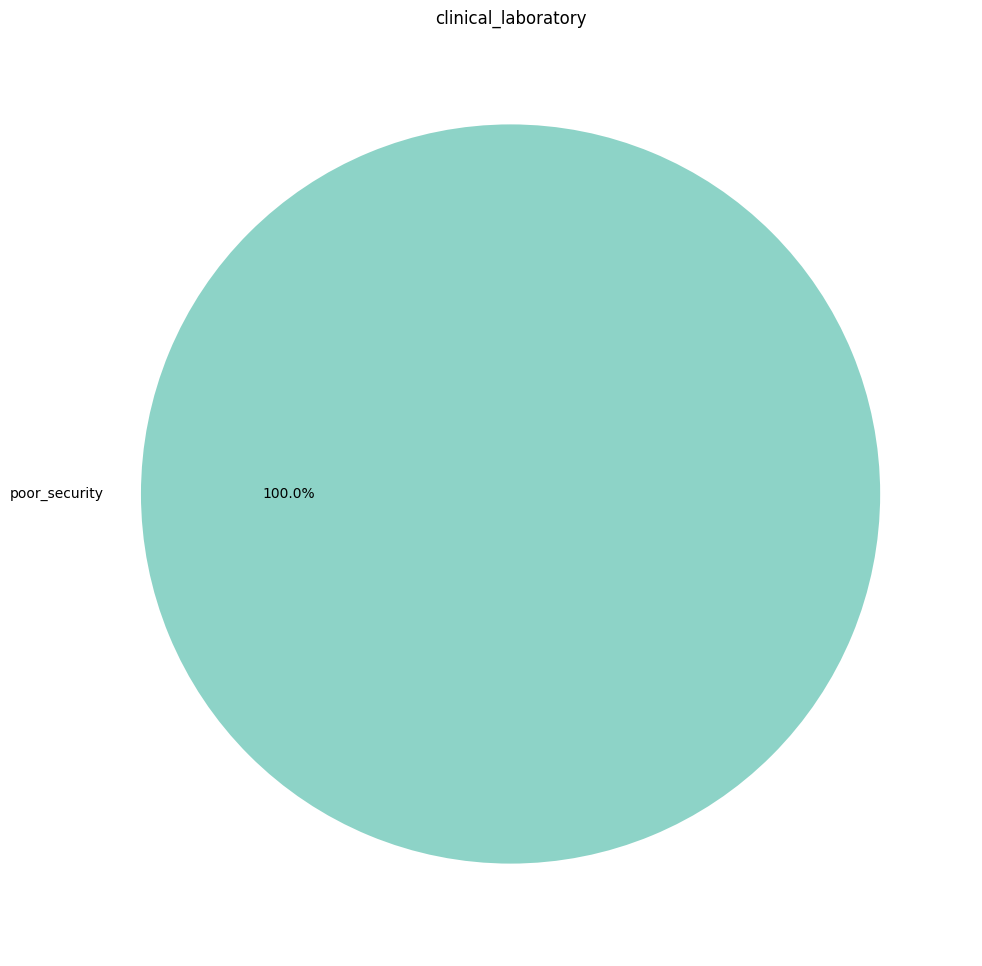

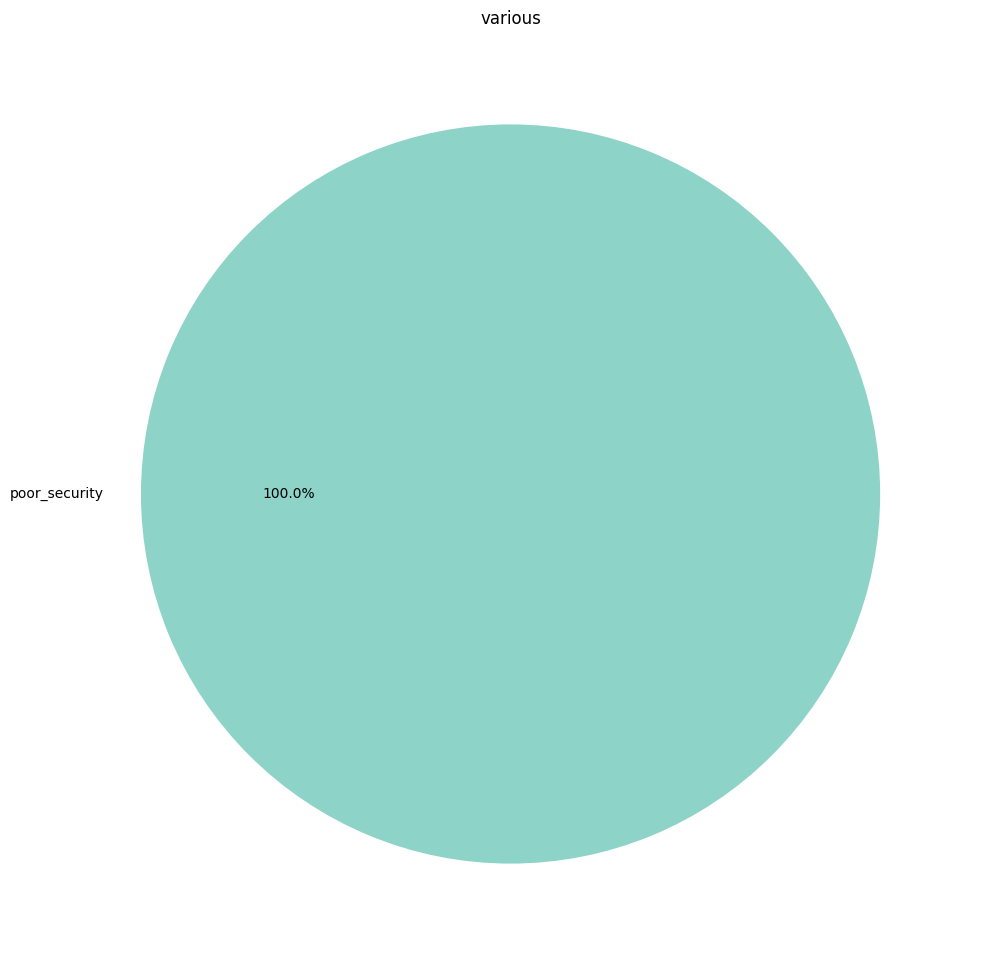

Plots saved successfully.


In [48]:
# Specify the directory to save the plots
output_directory = 'graphs'

# Create the directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)
organization_types = df_class['Organization type'].unique()
# Iterate over the organization types and create a pie chart for each
for org_type in organization_types:
    # Filter the data for the current organization type
    org_data = df_class[df_class['Organization type'] == org_type]
    
    # Get the unique methods for the current organization type
    methods = org_data['Method'].unique()
    
    # Get the counts for each method
    method_counts = org_data['Method'].value_counts()
    
    # Generate a list of colors for the pie chart
    colors = plt.cm.Set3(range(len(methods)))
    
    # Create the pie chart
    plt.figure(figsize=(12, 12))
    plt.pie(method_counts, labels=methods, colors=colors, autopct='%1.1f%%')
    plt.title(org_type)
    
    # Save the plot as a .png file in the specified directory
    output_filename = os.path.join(output_directory, f'{org_type}_breach_causes.png')
    plt.savefig(output_filename)
    plt.show()
    # Close the current plot to free up resources for the next iteration
    plt.close()

print("Plots saved successfully.")


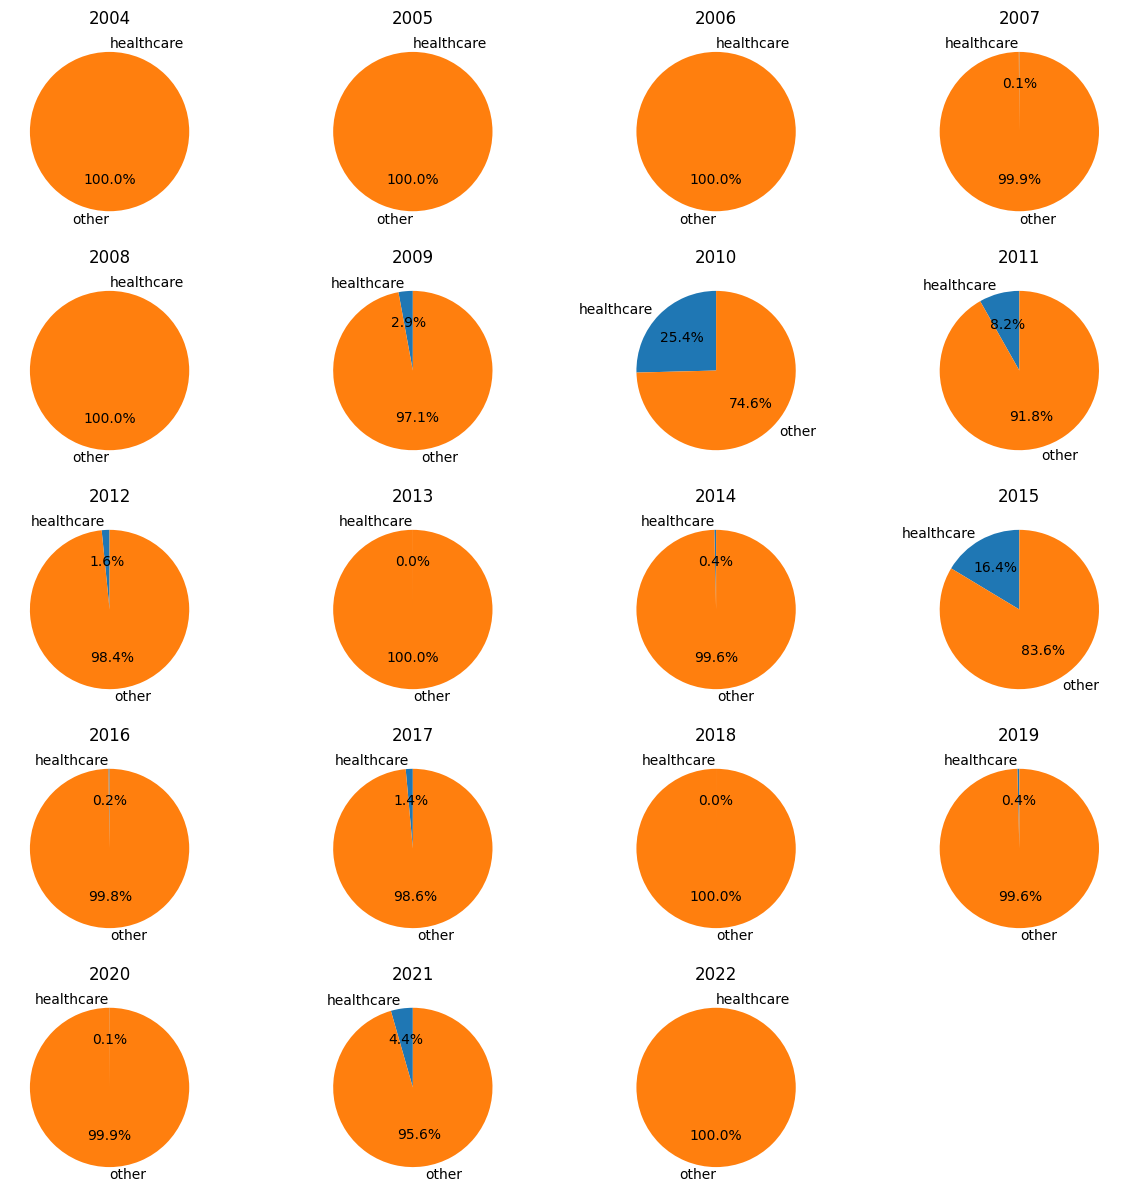

In [49]:
# Grouping the data by year and industry and summing the 'Records' column
records_by_year_and_industry = df_vis.groupby(['Year', 'Organization type'])['Records'].sum().unstack()

# Finding the top 20 industries based on total records
top_20_industries = records_by_year_and_industry.sum().sort_values(ascending=False).head(13).index

# Filtering the DataFrame to include all industries and filling NaN values with 0
records_by_year_and_industry_all = records_by_year_and_industry.fillna(0)

# Create a consolidated image for all pie charts
plt.figure(figsize=(15, 15))

# Create subplots based on the number of years
num_years = len(records_by_year_and_industry_all.index)
num_cols = 4 
num_rows = (num_years + num_cols - 1) // num_cols


for i, year in enumerate(records_by_year_and_industry_all.index, start=1):
    data_for_year = records_by_year_and_industry_all.loc[year]

    # Calculate the percentage of records lost in the healthcare industry and the rest
    #the total number of records lost that year where "Organization type == healthcare"
    healthcare_sum = data_for_year.groupby('Organization type').sum()['healthcare']
    healthcare_percentage = healthcare_sum / data_for_year.sum()
    other_percentage = 1 - healthcare_percentage

    # Create subplots
    plt.subplot(num_rows, num_cols, i)
    plt.pie([healthcare_percentage, other_percentage], labels=['healthcare', 'other'],
            autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '',
            startangle=90)
    plt.title(f"{year}")

plt.show()

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

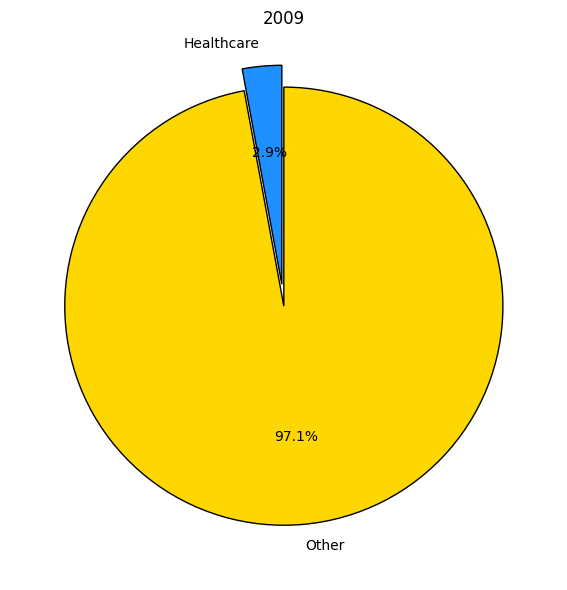

7403298.0


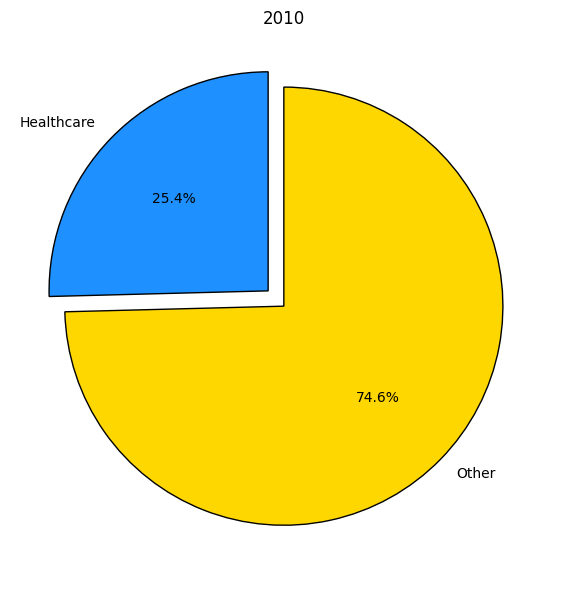

4060476.0


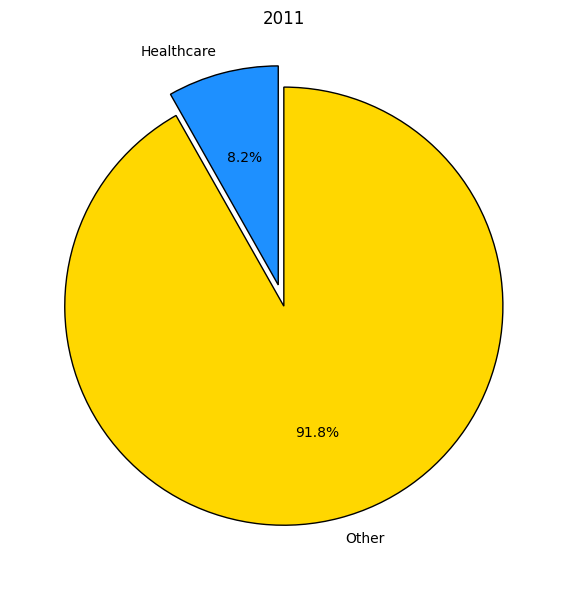

19266122.0


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

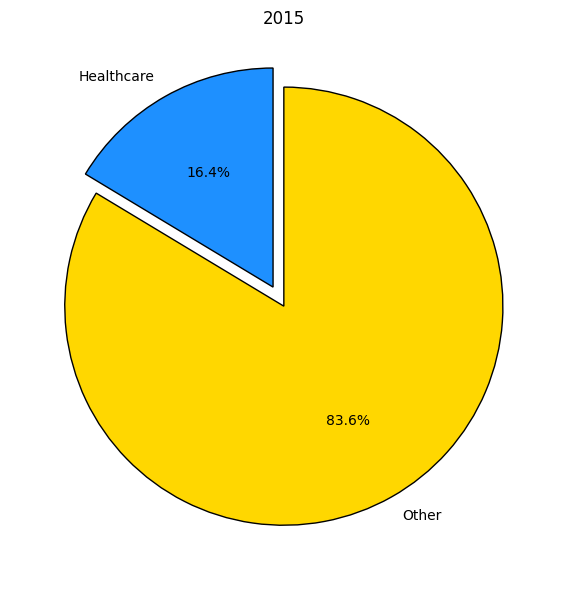

110500000.0


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

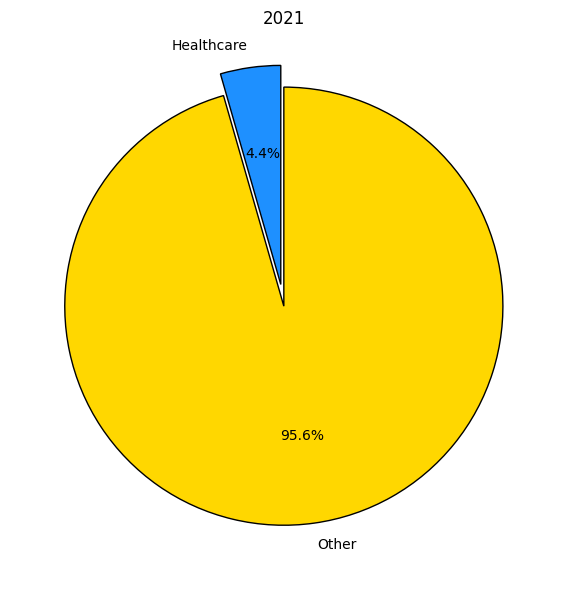

6067490.0


<Figure size 600x600 with 0 Axes>

In [50]:
# Grouping the data by year and industry and summing the 'Records' column
records_by_year_and_industry = df_vis.groupby(['Year', 'Organization type'])['Records'].sum().unstack()

# Finding the top 20 industries based on total records
top_20_industries = records_by_year_and_industry.sum().sort_values(ascending=False).head(13).index

# Filtering the DataFrame to include all industries and filling NaN values with 0
records_by_year_and_industry_all = records_by_year_and_industry.fillna(0)
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
# Creating explode data
explode = (0.1, 0.0)
# Create subplots for each year
for i, year in enumerate(records_by_year_and_industry_all.index, start=1):
    # Create a separate figure for each year
    plt.figure(figsize=(6, 6))

    data_for_year = records_by_year_and_industry_all.loc[year]

    # Calculate the percentage of records lost in the healthcare industry and the rest
    # the total number of records lost that year where "Organization type == healthcare"
    healthcare_sum = data_for_year.groupby('Organization type').sum().get('healthcare', 0)
    healthcare_percentage = healthcare_sum / data_for_year.sum()
    if healthcare_percentage > 0.02:
        
        other_percentage = 1 - healthcare_percentage

        # Create subplots
        plt.pie([healthcare_percentage, other_percentage], labels=['Healthcare', 'Other'],
                autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', wedgeprops=wp, explode = explode,
                colors = ['dodgerblue', 'gold'],
                startangle=90)
        plt.title(f"{year}")

        # Adjust layout
        plt.tight_layout()
        plt.show()
        print(healthcare_sum)

In [51]:
print(df_vis)
df_vis

     Year    Records Organization type         Method
0    2016    2200000        healthcare         hacked
1    2020   14870304            social         hacked
2    2020     175350        healthcare  poor_security
3    2013  152000000              tech         hacked
4    2019    7500000              tech  poor_security
..    ...        ...               ...            ...
346  2011    2450716          military  poor_security
347  2006   13250000        government  poor_security
348  2020   13250000        government         hacked
349  2009    4128689        government         hacked
350  2013   11000000              tech         hacked

[351 rows x 4 columns]


,Year,Records,Organization type,Method
0,2016,2200000,healthcare,hacked
1,2020,14870304,social,hacked
2,2020,175350,healthcare,poor_security
3,2013,152000000,tech,hacked
4,2019,7500000,tech,poor_security
...,...,...,...,...
346,2011,2450716,military,poor_security
347,2006,13250000,government,poor_security
348,2020,13250000,government,hacked
349,2009,4128689,government,hacked


## Label Encoding

In [52]:
le = LabelEncoder()  #perform label encoding on the organization_type, the copy of df_vis

# implement label encoding on the Organization type column
le.fit(df_vis['Organization type'])   # fit the data we want to train the encoder on
df_vis['Organization type'] = le.transform(df_vis['Organization type'])
# observe how the column 'Organization Type' has changed
df_vis.head()

,Year,Records,Organization type,Method
0,2016,2200000,9,hacked
1,2020,14870304,15,hacked
2,2020,175350,9,poor_security
3,2013,152000000,16,hacked
4,2019,7500000,16,poor_security


In [53]:
df_vis.dtypes   # as we can see, the Organization type changed from Object --> integer datatype

Year                  int64
Records               int64
Organization type     int64
Method               object
dtype: object

In [54]:
# observe the label frequency, to gain an understanding of outliers and inlier values
df_vis['Organization type'].value_counts()

Organization type
20    55
9     51
5     42
8     35
14    34
16    21
17    19
6     14
3     14
15    12
12    11
2     10
10     9
18     8
11     4
4      4
13     4
0      1
7      1
1      1
19     1
Name: count, dtype: int64

In [55]:
df_vis['Method']

0             hacked
1             hacked
2      poor_security
3             hacked
4      poor_security
           ...      
346    poor_security
347    poor_security
348           hacked
349           hacked
350           hacked
Name: Method, Length: 351, dtype: object

In [56]:
df_vis['Method'].unique()

array(['hacked', 'poor_security'], dtype=object)

In [57]:
df_vis['Method'].value_counts()     

Method
hacked           217
poor_security    134
Name: count, dtype: int64

In [58]:
#check which columns have null/unknoown values
null_mask = df_vis.isnull().any(axis=1)
null_rows=df_vis[null_mask]

print(null_rows)

Empty DataFrame
Columns: [Year, Records, Organization type, Method]
Index: []


In [59]:
df_vis.isnull().all()   

Year                 False
Records              False
Organization type    False
Method               False
dtype: bool

In [60]:
print(list(df_vis['Method'].unique()))  
print(len(list(df_vis['Method'].value_counts())) )

['hacked', 'poor_security']
2


In [61]:

le.fit(df_vis['Method'])  # train the label encoder on the column data we want to train
df_vis['Method'] = le.transform(df_vis['Method'])

In [62]:
df_vis.dtypes 

Year                 int64
Records              int64
Organization type    int64
Method               int64
dtype: object

In [63]:
print(df_vis['Method'].unique())

[0 1]


### READY TO TRAIN – Binary classification

In [65]:
features = ['Organization type']
label = 'Method'

X = df_vis[features]
y = df_vis[label]

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_standardized, dtype=torch.float32)
y_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32).reshape(-1, 1)

# Define the neural network model
model = nn.Sequential(
    nn.Linear(1, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1),
    nn.Sigmoid()
)

# Loss function and optimizer
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training parameters
n_epochs = 20
batch_size = 1

# Number of folds for cross-validation
n_splits = 15
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# List to store the performance metrics for each fold
fold_metrics = []

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
    print(f"\nFold {fold + 1}/{n_splits}")

    X_train_fold, X_val_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_val_fold = y_tensor[train_index], y_tensor[val_index]
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        for start in range(0, len(X_train_fold), batch_size):
            X_batch = X_train_fold[start:start+batch_size]
            y_batch = y_train_fold[start:start+batch_size]

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_fold)
        mse_val = loss_fn(y_pred_val, y_val_fold)
        fold_metrics.append(mse_val.item())
        y_pred_binary = (y_pred_val >= 0.5).float()

        # Calculate accuracy
        correct = (y_pred_binary == y_val_fold).sum().item()
        total = y_val_fold.size(0)
        accuracy = correct / total * 100.0

        print(f"Fold {fold + 1} - Validation MSE: {mse_val:.4f} - Accuracy: {accuracy:.2f}%")





Fold 1/15
Fold 1 - Validation MSE: 0.6322 - Accuracy: 70.83%

Fold 2/15
Fold 2 - Validation MSE: 0.6718 - Accuracy: 54.17%

Fold 3/15
Fold 3 - Validation MSE: 0.7046 - Accuracy: 50.00%

Fold 4/15
Fold 4 - Validation MSE: 0.7445 - Accuracy: 45.83%

Fold 5/15
Fold 5 - Validation MSE: 0.6931 - Accuracy: 41.67%

Fold 6/15
Fold 6 - Validation MSE: 0.6591 - Accuracy: 62.50%

Fold 7/15
Fold 7 - Validation MSE: 0.6488 - Accuracy: 56.52%

Fold 8/15
Fold 8 - Validation MSE: 0.6122 - Accuracy: 69.57%

Fold 9/15
Fold 9 - Validation MSE: 0.6555 - Accuracy: 56.52%

Fold 10/15
Fold 10 - Validation MSE: 0.6981 - Accuracy: 56.52%

Fold 11/15
Fold 11 - Validation MSE: 0.6205 - Accuracy: 69.57%

Fold 12/15
Fold 12 - Validation MSE: 0.6023 - Accuracy: 60.87%

Fold 13/15
Fold 13 - Validation MSE: 0.6084 - Accuracy: 65.22%

Fold 14/15
Fold 14 - Validation MSE: 0.7161 - Accuracy: 65.22%

Fold 15/15
Fold 15 - Validation MSE: 0.5261 - Accuracy: 82.61%


Fold 1/15
Fold 1 - Validation MSE: 0.6542 - Accuracy: 70.83%

Fold 2/15
Fold 2 - Validation MSE: 0.6355 - Accuracy: 54.17%

Fold 3/15
Fold 3 - Validation MSE: 0.7007 - Accuracy: 50.00%

Fold 4/15
Fold 4 - Validation MSE: 0.7450 - Accuracy: 45.83%

Fold 5/15
Fold 5 - Validation MSE: 0.6813 - Accuracy: 41.67%

Fold 6/15
Fold 6 - Validation MSE: 0.6768 - Accuracy: 62.50%

Fold 7/15
Fold 7 - Validation MSE: 0.6519 - Accuracy: 69.57%

Fold 8/15
Fold 8 - Validation MSE: 0.6211 - Accuracy: 73.91%

Fold 9/15
Fold 9 - Validation MSE: 0.6427 - Accuracy: 52.17%

Fold 10/15
Fold 10 - Validation MSE: 0.6925 - Accuracy: 60.87%

Fold 11/15
Fold 11 - Validation MSE: 0.6186 - Accuracy: 60.87%

Fold 12/15
Fold 12 - Validation MSE: 0.5808 - Accuracy: 69.57%

Fold 13/15
Fold 13 - Validation MSE: 0.6072 - Accuracy: 69.57%

Fold 14/15
Fold 14 - Validation MSE: 0.7312 - Accuracy: 60.87%

Fold 15/15
Fold 15 - Validation MSE: 0.5168 - Accuracy: 82.61%

Data visualization on multiclass dataset

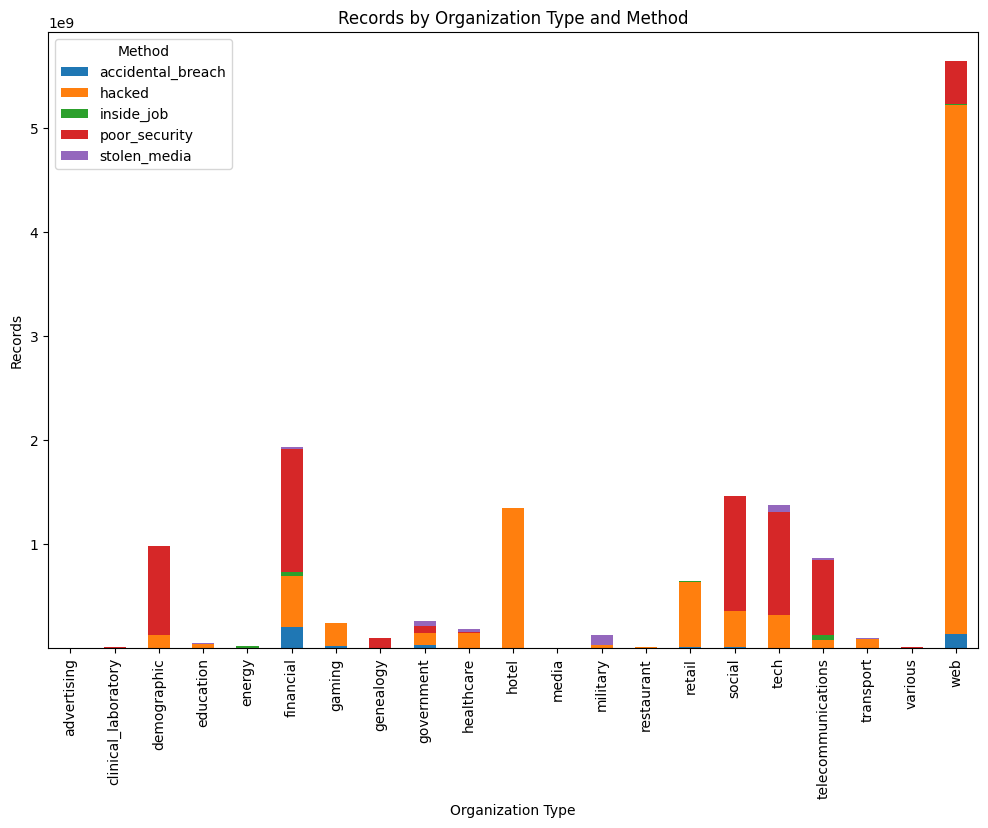

In [66]:
# Group the data by organization type and method, and sum the records for each combination
grouped_data = df_class.groupby(['Organization type', 'Method'])['Records'].sum().unstack()

# Create a stacked bar plot
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8))

# Add labels and title
plt.title('Records by Organization Type and Method')
plt.xlabel('Organization Type')
plt.ylabel('Records')

# Display the plot
plt.show()


Neural Network – Multiclass Classification

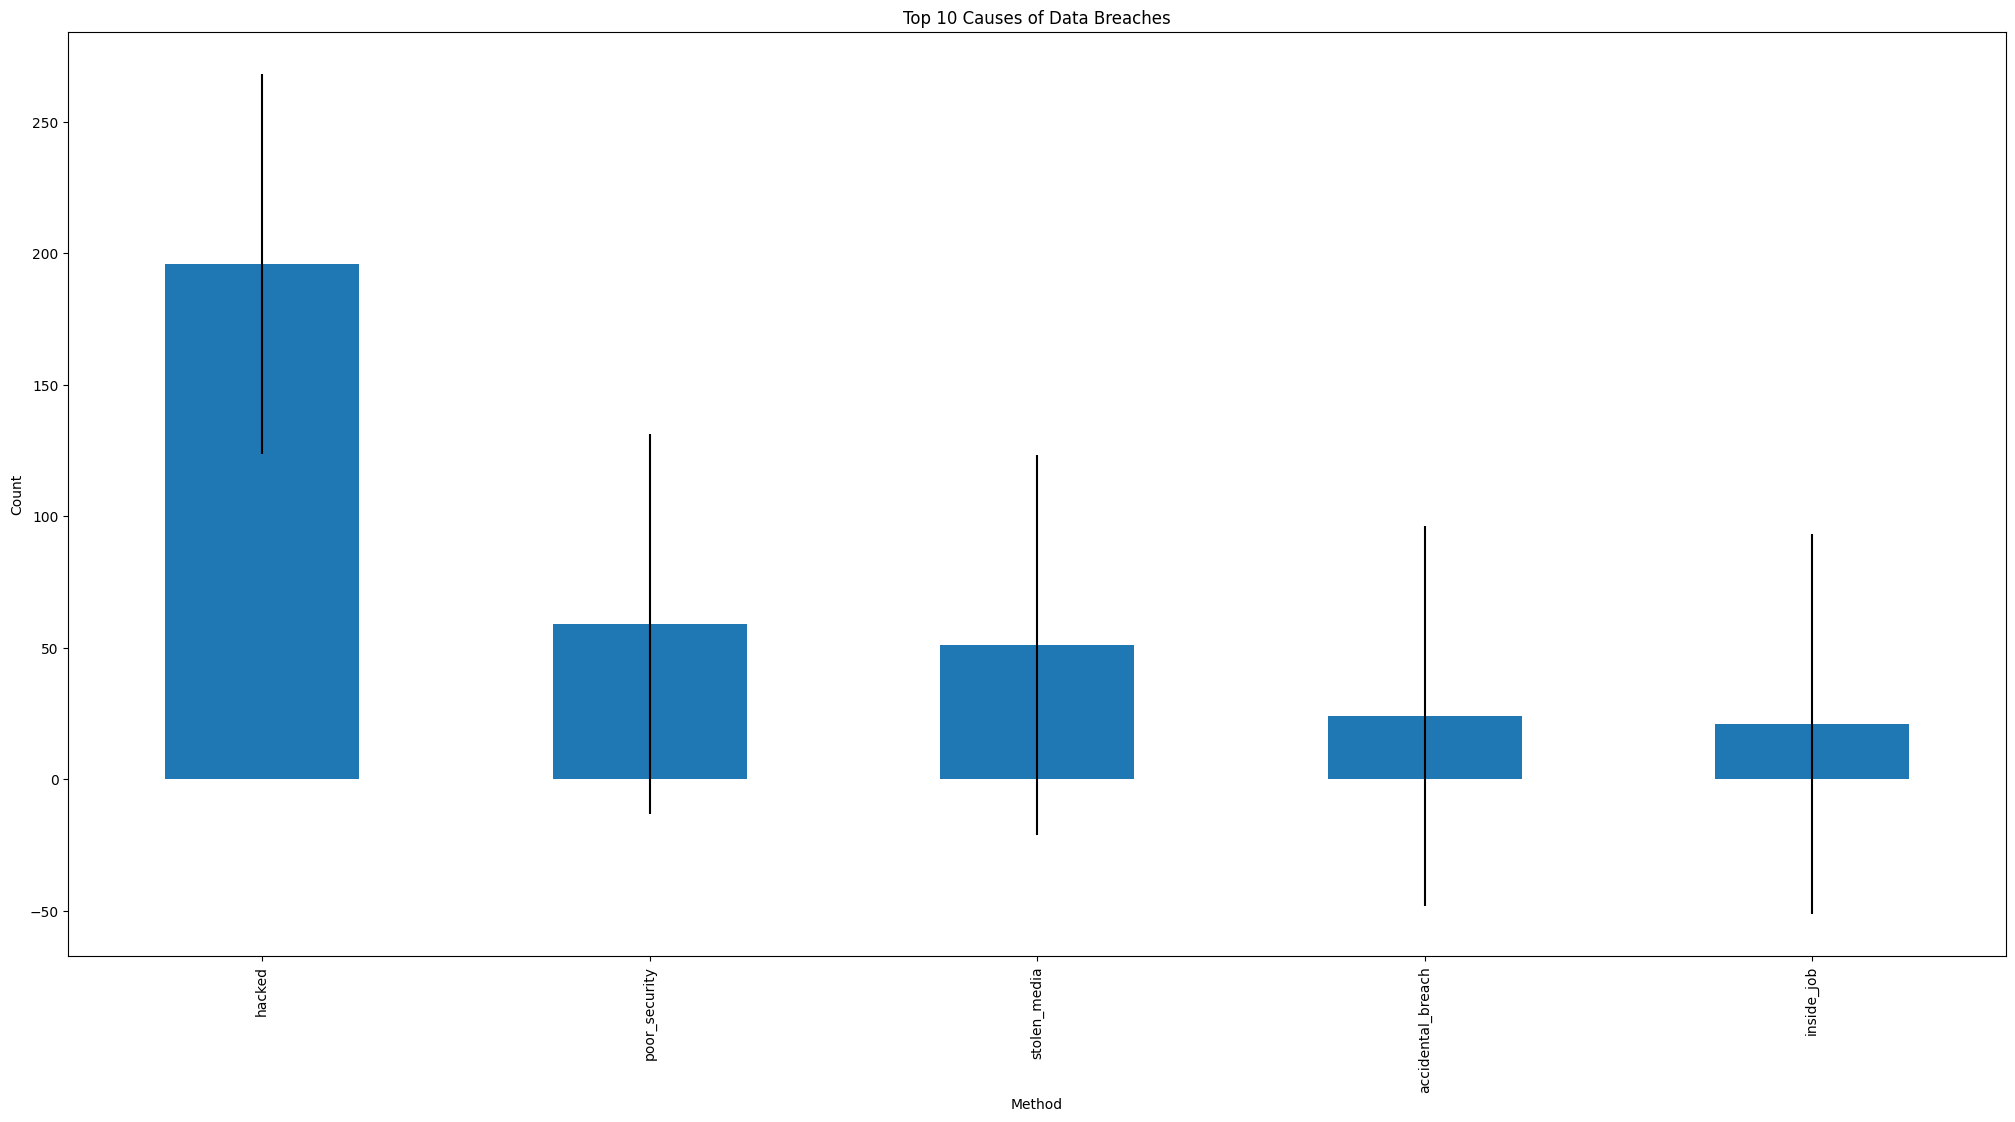

['hacked' 'poor_security' 'stolen_media' 'accidental_breach' 'inside_job']
Method
hacked               196
poor_security         59
stolen_media          51
accidental_breach     24
inside_job            21
Name: count, dtype: int64
   Year    Records  Organization type  Method
0  2016    2200000                  9       1
1  2020   14870304                 15       1
2  2020     175350                  9       3
3  2013  152000000                 16       1
4  2019    7500000                 16       3


In [67]:
df_class.drop("Entity", axis=1, inplace=True)
df_class["Records"] = df_class["Records"].astype(int)
# Group the data by the method and count the occurrences, then select the top 10 causes
top_10_causes = df_class['Method'].value_counts().nlargest(10)

# Create a bar plot for the top 10 causes of data breaches
top_10_causes.plot(kind='bar', figsize=(25, 12))
plt.title("Top 10 Causes of Data Breaches")
plt.xlabel("Cause")
plt.ylabel("Count")
plt.xticks(rotation=90)
top_10_causes.plot(kind='bar', figsize=(25, 12), yerr=df_class['Method'].value_counts().std())
plt.show()

print(df_class['Method'].unique())
print(df_class['Method'].value_counts())

le = LabelEncoder()  #perform label encoding on the organization_type, the copy of df_vis

# implement label encoding on the Organization type column
le.fit(df_class['Organization type'])   # fit the data we want to train the encoder on
df_class['Organization type'] = le.transform(df_class['Organization type'])
le.fit(df_class['Method'])  # train the label encoder on the column data we want to train
df_class['Method'] = le.transform(df_class['Method'])
print(df_class.head())



In [68]:
# Define the neural network model
model = nn.Sequential(
    nn.Linear(1, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 5)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training parameters
n_epochs = 20
batch_size = 1

# Number of folds for cross-validation
n_splits = 15
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# List to store the performance metrics for each fold
fold_metrics = []

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
    print(f"\nFold {fold + 1}/{n_splits}")

    X_train_fold, X_val_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_val_fold = y_tensor[train_index], y_tensor[val_index]
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        for start in range(0, len(X_train_fold), batch_size):
            X_batch = X_train_fold[start:start+batch_size]
            y_batch = y_train_fold[start:start+batch_size]

            y_pred = model(X_batch)
            
            # Ensure that y_batch contains class indices
            y_batch = y_batch.long().squeeze(dim=1)

            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_fold)
        
        # Ensure that y_val_fold contains class indices
        y_val_fold = y_val_fold.long().squeeze(dim=1)

        loss_val = loss_fn(y_pred_val, y_val_fold)
        fold_metrics.append(loss_val.item())

        # Convert logits to predicted class
        y_pred_classes = torch.argmax(y_pred_val, dim=1)

        # Calculate accuracy
        correct = (y_pred_classes == y_val_fold).sum().item()
        total = y_val_fold.size(0)
        accuracy = correct / total * 100.0

        print(f"Fold {fold + 1} - Validation Loss: {loss_val:.4f} - Accuracy: {accuracy:.2f}%")




Fold 1/15
Fold 1 - Validation Loss: 0.6507 - Accuracy: 70.83%

Fold 2/15
Fold 2 - Validation Loss: 0.6161 - Accuracy: 54.17%

Fold 3/15
Fold 3 - Validation Loss: 0.6923 - Accuracy: 50.00%

Fold 4/15
Fold 4 - Validation Loss: 0.7632 - Accuracy: 45.83%

Fold 5/15
Fold 5 - Validation Loss: 0.6763 - Accuracy: 41.67%

Fold 6/15
Fold 6 - Validation Loss: 0.6784 - Accuracy: 62.50%

Fold 7/15
Fold 7 - Validation Loss: 0.6482 - Accuracy: 69.57%

Fold 8/15
Fold 8 - Validation Loss: 0.6239 - Accuracy: 73.91%

Fold 9/15
Fold 9 - Validation Loss: 0.6528 - Accuracy: 52.17%

Fold 10/15
Fold 10 - Validation Loss: 0.6906 - Accuracy: 60.87%

Fold 11/15
Fold 11 - Validation Loss: 0.6287 - Accuracy: 60.87%

Fold 12/15
Fold 12 - Validation Loss: 0.5868 - Accuracy: 73.91%

Fold 13/15
Fold 13 - Validation Loss: 0.6069 - Accuracy: 69.57%

Fold 14/15
Fold 14 - Validation Loss: 0.7233 - Accuracy: 60.87%

Fold 15/15
Fold 15 - Validation Loss: 0.5295 - Accuracy: 82.61%


Fold 1/15
Fold 1 - Validation Loss: 0.6366 - Accuracy: 70.83%

Fold 2/15
Fold 2 - Validation Loss: 0.6561 - Accuracy: 54.17%

Fold 3/15
Fold 3 - Validation Loss: 0.7103 - Accuracy: 50.00%

Fold 4/15
Fold 4 - Validation Loss: 0.7385 - Accuracy: 45.83%

Fold 5/15
Fold 5 - Validation Loss: 0.7130 - Accuracy: 41.67%

Fold 6/15
Fold 6 - Validation Loss: 0.6728 - Accuracy: 62.50%

Fold 7/15
Fold 7 - Validation Loss: 0.6652 - Accuracy: 69.57%

Fold 8/15
Fold 8 - Validation Loss: 0.6181 - Accuracy: 73.91%

Fold 9/15
Fold 9 - Validation Loss: 0.6851 - Accuracy: 52.17%

Fold 10/15
Fold 10 - Validation Loss: 0.6841 - Accuracy: 60.87%

Fold 11/15
Fold 11 - Validation Loss: 0.6212 - Accuracy: 60.87%

Fold 12/15
Fold 12 - Validation Loss: 0.5791 - Accuracy: 73.91%

Fold 13/15
Fold 13 - Validation Loss: 0.6183 - Accuracy: 69.57%

Fold 14/15
Fold 14 - Validation Loss: 0.7136 - Accuracy: 60.87%

Fold 15/15
Fold 15 - Validation Loss: 0.5137 - Accuracy: 82.61%

In [74]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

features = ['Organization type', 'Records']
label = 'Method'

X = df_class[features]
y = df_class[label]

# Use LabelEncoder for 'Organization type' to convert it into numerical values
label_encoder = LabelEncoder()
X['Organization type'] = label_encoder.fit_transform(X['Organization type'])

# One-hot encode 'Organization type'
onehot_encoder = OneHotEncoder(sparse=False)
org_type_encoded = onehot_encoder.fit_transform(X['Organization type'].values.reshape(-1, 1))
org_type_encoded = pd.DataFrame(org_type_encoded, columns=[f'org_type_{i}' for i in range(org_type_encoded.shape[1])])

# Concatenate the one-hot encoded 'Organization type' with the 'Records' column
X = pd.concat([org_type_encoded, X['Records']], axis=1)

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_standardized, dtype=torch.float32)
y_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32).reshape(-1, 1)

# Define the neural network model
model = nn.Sequential(
    nn.Linear(X_tensor.shape[1], 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.Softmax(dim=1)  # Softmax for multi-class classification
)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training parameters
n_epochs = 20
batch_size = 1

# Number of folds for cross-validation
n_splits = 15
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# List to store the performance metrics for each fold
fold_metrics = []

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
    print(f"\nFold {fold + 1}/{n_splits}")

    X_train_fold, X_val_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_val_fold = y_tensor[train_index], y_tensor[val_index]
    
    # Training loop
    for epoch in range(n_epochs):
        model.train()
        for start in range(0, len(X_train_fold), batch_size):
            X_batch = X_train_fold[start:start+batch_size]
            y_batch = y_train_fold[start:start+batch_size].squeeze().long()

            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()



    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_fold).squeeze()
        mse_val = loss_fn(y_pred_val, y_val_fold.squeeze().long())
        fold_metrics.append(mse_val.item())
        
        y_pred_classes = torch.argmax(y_pred_val, dim=1)[:len(y_val_fold)]

        # Calculate accuracy
        correct = (y_pred_classes == y_val_fold.squeeze()).sum().item()
        total = len(y_val_fold)
        accuracy = correct / total * 100.0
        print(f"Fold {fold + 1} - Validation MSE: {mse_val:.4f} - Accuracy: {accuracy:.2f}%")


/var/folders/sk/r_8fkf9s2ys9d8p1lfwj100r0000gn/T/ipykernel_49114/3247898054.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Organization type'] = label_encoder.fit_transform(X['Organization type'])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Fold 1/15
Fold 1 - Validation MSE: 1.3994 - Accuracy: 66.67%

Fold 2/15
Fold 2 - Validation MSE: 1.5664 - Accuracy: 45.83%

Fold 3/15
Fold 3 - Validation MSE: 1.4994 - Accuracy: 54.17%

Fold 4/15
Fold 4 - Validation MSE: 1.5260 - Accuracy: 50.00%

Fold 5/15
Fold 5 - Validation MSE: 1.6066 - Accuracy: 41.67%

Fold 6/15
Fold 6 - Validation MSE: 1.3667 - Accuracy: 70.83%

Fold 7/15
Fold 7 - Validation MSE: 1.4249 - Accuracy: 65.22%

Fold 8/15
Fold 8 - Validation MSE: 1.3730 - Accuracy: 69.57%

Fold 9/15
Fold 9 - Validation MSE: 1.5247 - Accuracy: 47.83%

Fold 10/15
Fold 10 - Validation MSE: 1.5220 - Accuracy: 52.17%

Fold 11/15
Fold 11 - Validation MSE: 1.4663 - Accuracy: 52.17%

Fold 12/15
Fold 12 - Validation MSE: 1.3240 - Accuracy: 69.57%

Fold 13/15
Fold 13 - Validation MSE: 1.4824 - Accuracy: 56.52%

Fold 14/15
Fold 14 - Validation MSE: 1.4123 - Accuracy: 60.87%

Fold 15/15
Fold 15 - Validation MSE: 1.2891 - Accuracy: 78.26%


Fold 1/15
Fold 1 - Validation MSE: 1.3994 - Accuracy: 66.67%

Fold 2/15
Fold 2 - Validation MSE: 1.5664 - Accuracy: 45.83%

Fold 3/15
Fold 3 - Validation MSE: 1.4994 - Accuracy: 54.17%

Fold 4/15
Fold 4 - Validation MSE: 1.5260 - Accuracy: 50.00%

Fold 5/15
Fold 5 - Validation MSE: 1.6066 - Accuracy: 41.67%

Fold 6/15
Fold 6 - Validation MSE: 1.3667 - Accuracy: 70.83%

Fold 7/15
Fold 7 - Validation MSE: 1.4249 - Accuracy: 65.22%

Fold 8/15
Fold 8 - Validation MSE: 1.3730 - Accuracy: 69.57%

Fold 9/15
Fold 9 - Validation MSE: 1.5247 - Accuracy: 47.83%

Fold 10/15
Fold 10 - Validation MSE: 1.5220 - Accuracy: 52.17%

Fold 11/15
Fold 11 - Validation MSE: 1.4663 - Accuracy: 52.17%

Fold 12/15
Fold 12 - Validation MSE: 1.3240 - Accuracy: 69.57%

Fold 13/15
Fold 13 - Validation MSE: 1.4824 - Accuracy: 56.52%

Fold 14/15
Fold 14 - Validation MSE: 1.4123 - Accuracy: 60.87%

Fold 15/15
Fold 15 - Validation MSE: 1.2891 - Accuracy: 78.26%

In [79]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

features = ['Organization type', 'Records']
label = 'Method'

X = df_class[features]
y = df_class[label]

# Use LabelEncoder for 'Organization type' to convert it into numerical values
label_encoder = LabelEncoder()
X['Organization type'] = label_encoder.fit_transform(X['Organization type'])

# One-hot encode 'Organization type'
onehot_encoder = OneHotEncoder(sparse=False)
org_type_encoded = onehot_encoder.fit_transform(X['Organization type'].values.reshape(-1, 1))
org_type_encoded = pd.DataFrame(org_type_encoded, columns=[f'org_type_{i}' for i in range(org_type_encoded.shape[1])])

# Concatenate the one-hot encoded 'Organization type' with the 'Records' column
X = pd.concat([org_type_encoded, X['Records']], axis=1)

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_standardized, dtype=torch.float32)
y_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32).reshape(-1, 1)

# Define the neural network model
model = nn.Sequential(
    nn.Linear(X_tensor.shape[1], 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)  # Linear output layer for regression
)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training parameters
n_epochs = 20
batch_size = 1

# Number of folds for cross-validation
n_splits = 15
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# List to store the performance metrics for each fold
fold_metrics = []
fold_residuals = []

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
    print(f"\nFold {fold + 1}/{n_splits}")

    X_train_fold, X_val_fold = X_tensor[train_index], X_tensor[val_index]
    y_train_fold, y_val_fold = y_tensor[train_index], y_tensor[val_index]

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        for start in range(0, len(X_train_fold), batch_size):
            X_batch = X_train_fold[start:start+batch_size]
            y_batch = y_train_fold[start:start+batch_size]

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_fold).squeeze()
        mse_val = loss_fn(y_pred_val, y_val_fold.squeeze())
        fold_metrics.append(mse_val.item())

        # Calculate residuals
        residuals = y_val_fold.squeeze().numpy() - y_pred_val.numpy()
        fold_residuals.append(residuals)

        # Calculate average residuals
        avg_residuals = sum(residuals) / len(residuals)

        print(f"Fold {fold + 1} - Validation MSE: {mse_val:.4f} - Average Residuals: {avg_residuals:.4f}")



/var/folders/sk/r_8fkf9s2ys9d8p1lfwj100r0000gn/T/ipykernel_49114/2679269157.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Organization type'] = label_encoder.fit_transform(X['Organization type'])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Fold 1/15
Fold 1 - Validation MSE: 1.3405 - Average Residuals: -0.2569

Fold 2/15
Fold 2 - Validation MSE: 1.2081 - Average Residuals: 0.3014

Fold 3/15
Fold 3 - Validation MSE: 1.2928 - Average Residuals: 0.0528

Fold 4/15
Fold 4 - Validation MSE: 2.0821 - Average Residuals: 0.0983

Fold 5/15
Fold 5 - Validation MSE: 1.8029 - Average Residuals: 0.6144

Fold 6/15
Fold 6 - Validation MSE: 1.0615 - Average Residuals: -0.2460

Fold 7/15
Fold 7 - Validation MSE: 1.1350 - Average Residuals: -0.1722

Fold 8/15
Fold 8 - Validation MSE: 0.8958 - Average Residuals: -0.0971

Fold 9/15
Fold 9 - Validation MSE: 1.7300 - Average Residuals: 0.1440

Fold 10/15
Fold 10 - Validation MSE: 1.4821 - Average Residuals: -0.0027

Fold 11/15
Fold 11 - Validation MSE: 1.3373 - Average Residuals: 0.1126

Fold 12/15
Fold 12 - Validation MSE: 0.9729 - Average Residuals: 0.0020

Fold 13/15
Fold 13 - Validation MSE: 1.1575 - Average Residuals: -0.1982

Fold 14/15
Fold 14 - Validation MSE: 1.3784 - Average Residual

positive residuals indicate that the model underpredicted, while negative residuals indicate that the model overpredicted.